In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import gpytorch
from tqdm.notebook import trange
import heapq
import math
from algorithms.cd import con_div
from algorithms.ccr import con_conv_rate

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 970M
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [20]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

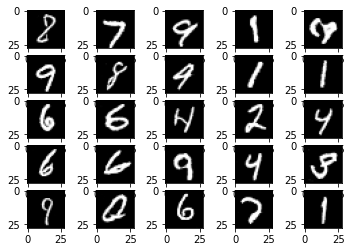

In [23]:
num_gpu = 1 if torch.cuda.is_available() else 0

# load the models
from models.dcgan_mnist import Discriminator, Generator

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('../MNIST_DCGAN/netD_epoch_99.pth'))
G.load_state_dict(torch.load('../MNIST_DCGAN/netG_epoch_99.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

batch_size = 1
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

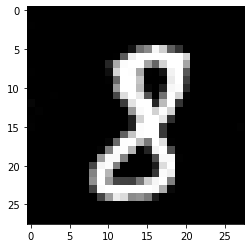

In [44]:
fixed_noise = torch.randn(1, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
plt.imshow(fake_images_np[0], cmap='gray')
plt.show()

## Dataset

In [4]:
def sample_GMM(means, covs, num_samples):
    """
    Samples equally from clusters of normal distributions.
    """
    assert(means.shape[0] == covs.shape[0])
    assert(means.shape[1] == covs.shape[1])
    assert(covs.shape[1] == covs.shape[2])
    
    n = means.shape[0]
    d = means.shape[1]
    samples = np.zeros((num_samples, d))
    
    for i in range(num_samples):
        cluster = np.random.randint(n)
        samples[i] = np.random.multivariate_normal(means[cluster], covs[cluster], check_valid='raise')
    
    return samples

In [5]:
num_clusters = 5
d = 2
num_samples = 1000

In [6]:
np.random.seed(2)

In [7]:
means = np.random.uniform(size=(num_clusters, d))
covs = np.zeros((num_clusters, d, d))
for i in range(num_clusters):
    covs[i] = np.eye(d)/200

In [8]:
train_sets = np.zeros((num_clusters, num_samples, d))
test_sets = np.zeros((num_clusters, num_samples, d))

In [9]:
for i in range(num_clusters):
    train_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')
    test_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')

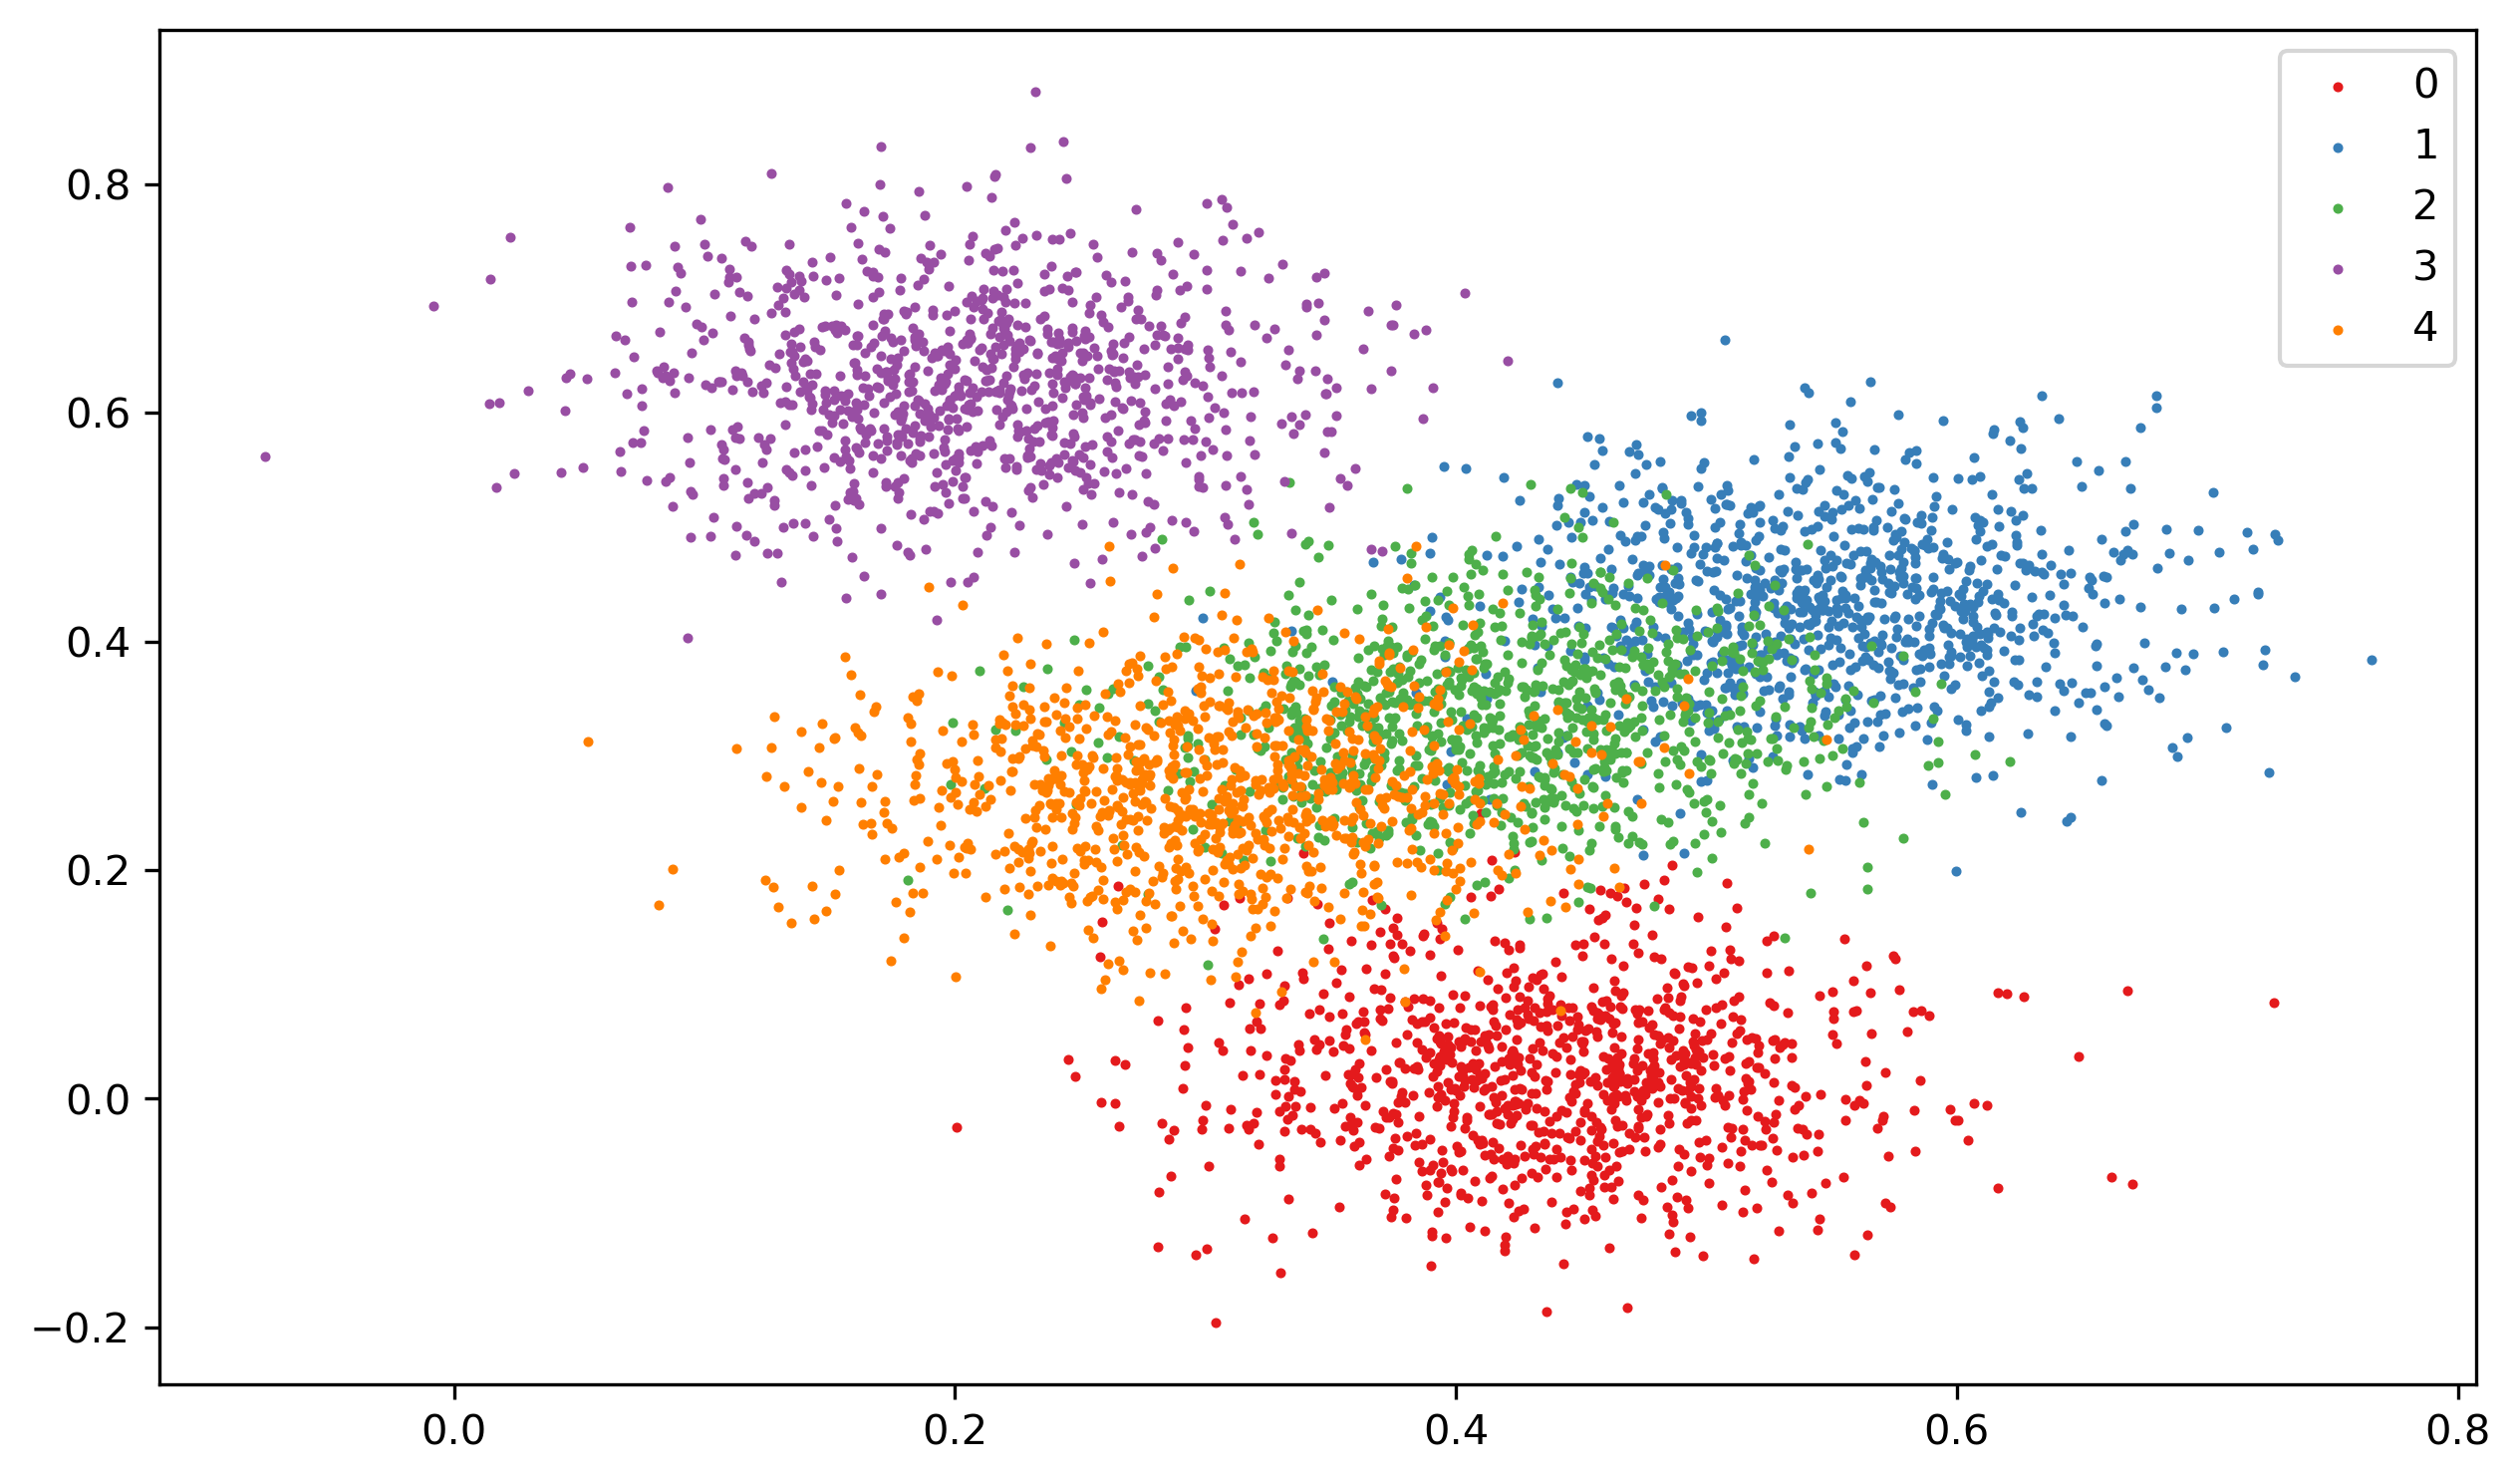

In [10]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif"})

plt.figure(figsize=(10, 6), dpi=300)
#plt.gca().set_aspect('equal', adjustable='box')
for i in range(num_clusters):
    plt.scatter(train_sets[i, :, 0], train_sets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))

    plt.legend()

## Controlled divergence (CD)

In [11]:
candidates = np.array([sample_GMM(means, covs, 5000) for i in range(num_clusters)])
reference = sample_GMM(means, covs, num_samples)
phi = [0, 0.25, 0.5, 0.75, 1]

In [12]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
kernel.base_kernel.lengthscale = [1, 1]
kernel.outputscale = 1

In [13]:
res = con_div(candidates, reference, phi, test_sets, kernel)

Running greedy algorithm with a -MMD^2 target of -0.0001076686766470214



Running greedy algorithm with a -MMD^2 target of -7.127601805070882e-05



Running greedy algorithm with a -MMD^2 target of -3.4883359454396246e-05



Running greedy algorithm with a -MMD^2 target of 1.5092991419163315e-06



Running greedy algorithm with a -MMD^2 target of 3.790195773822891e-05


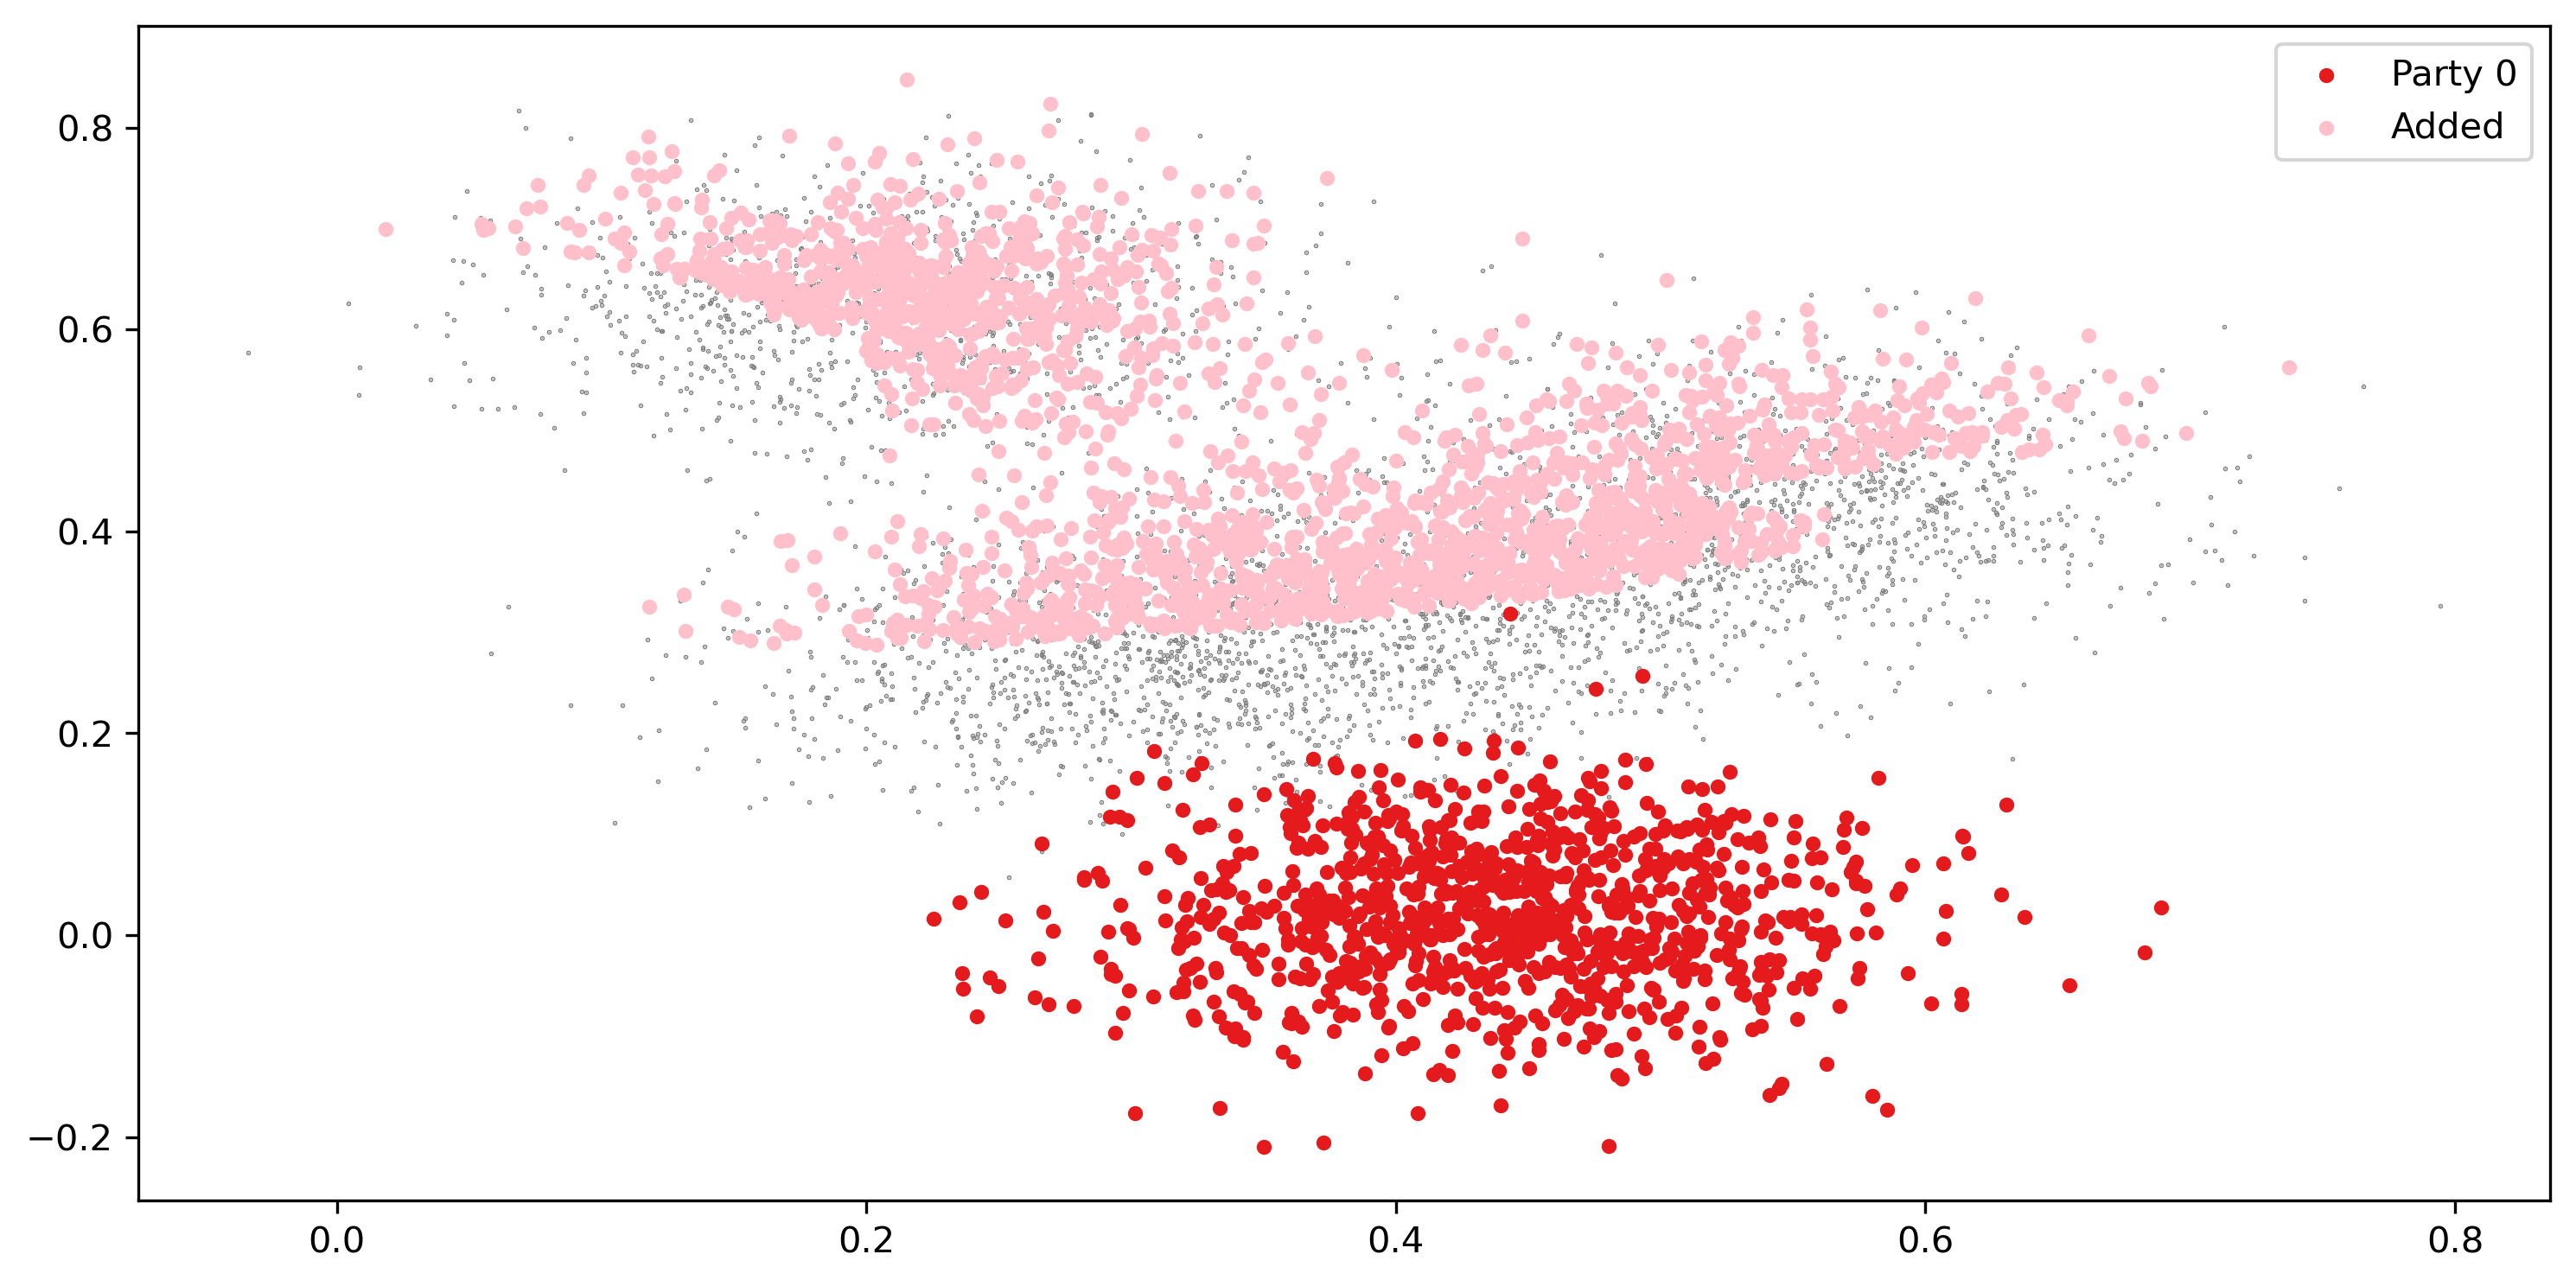

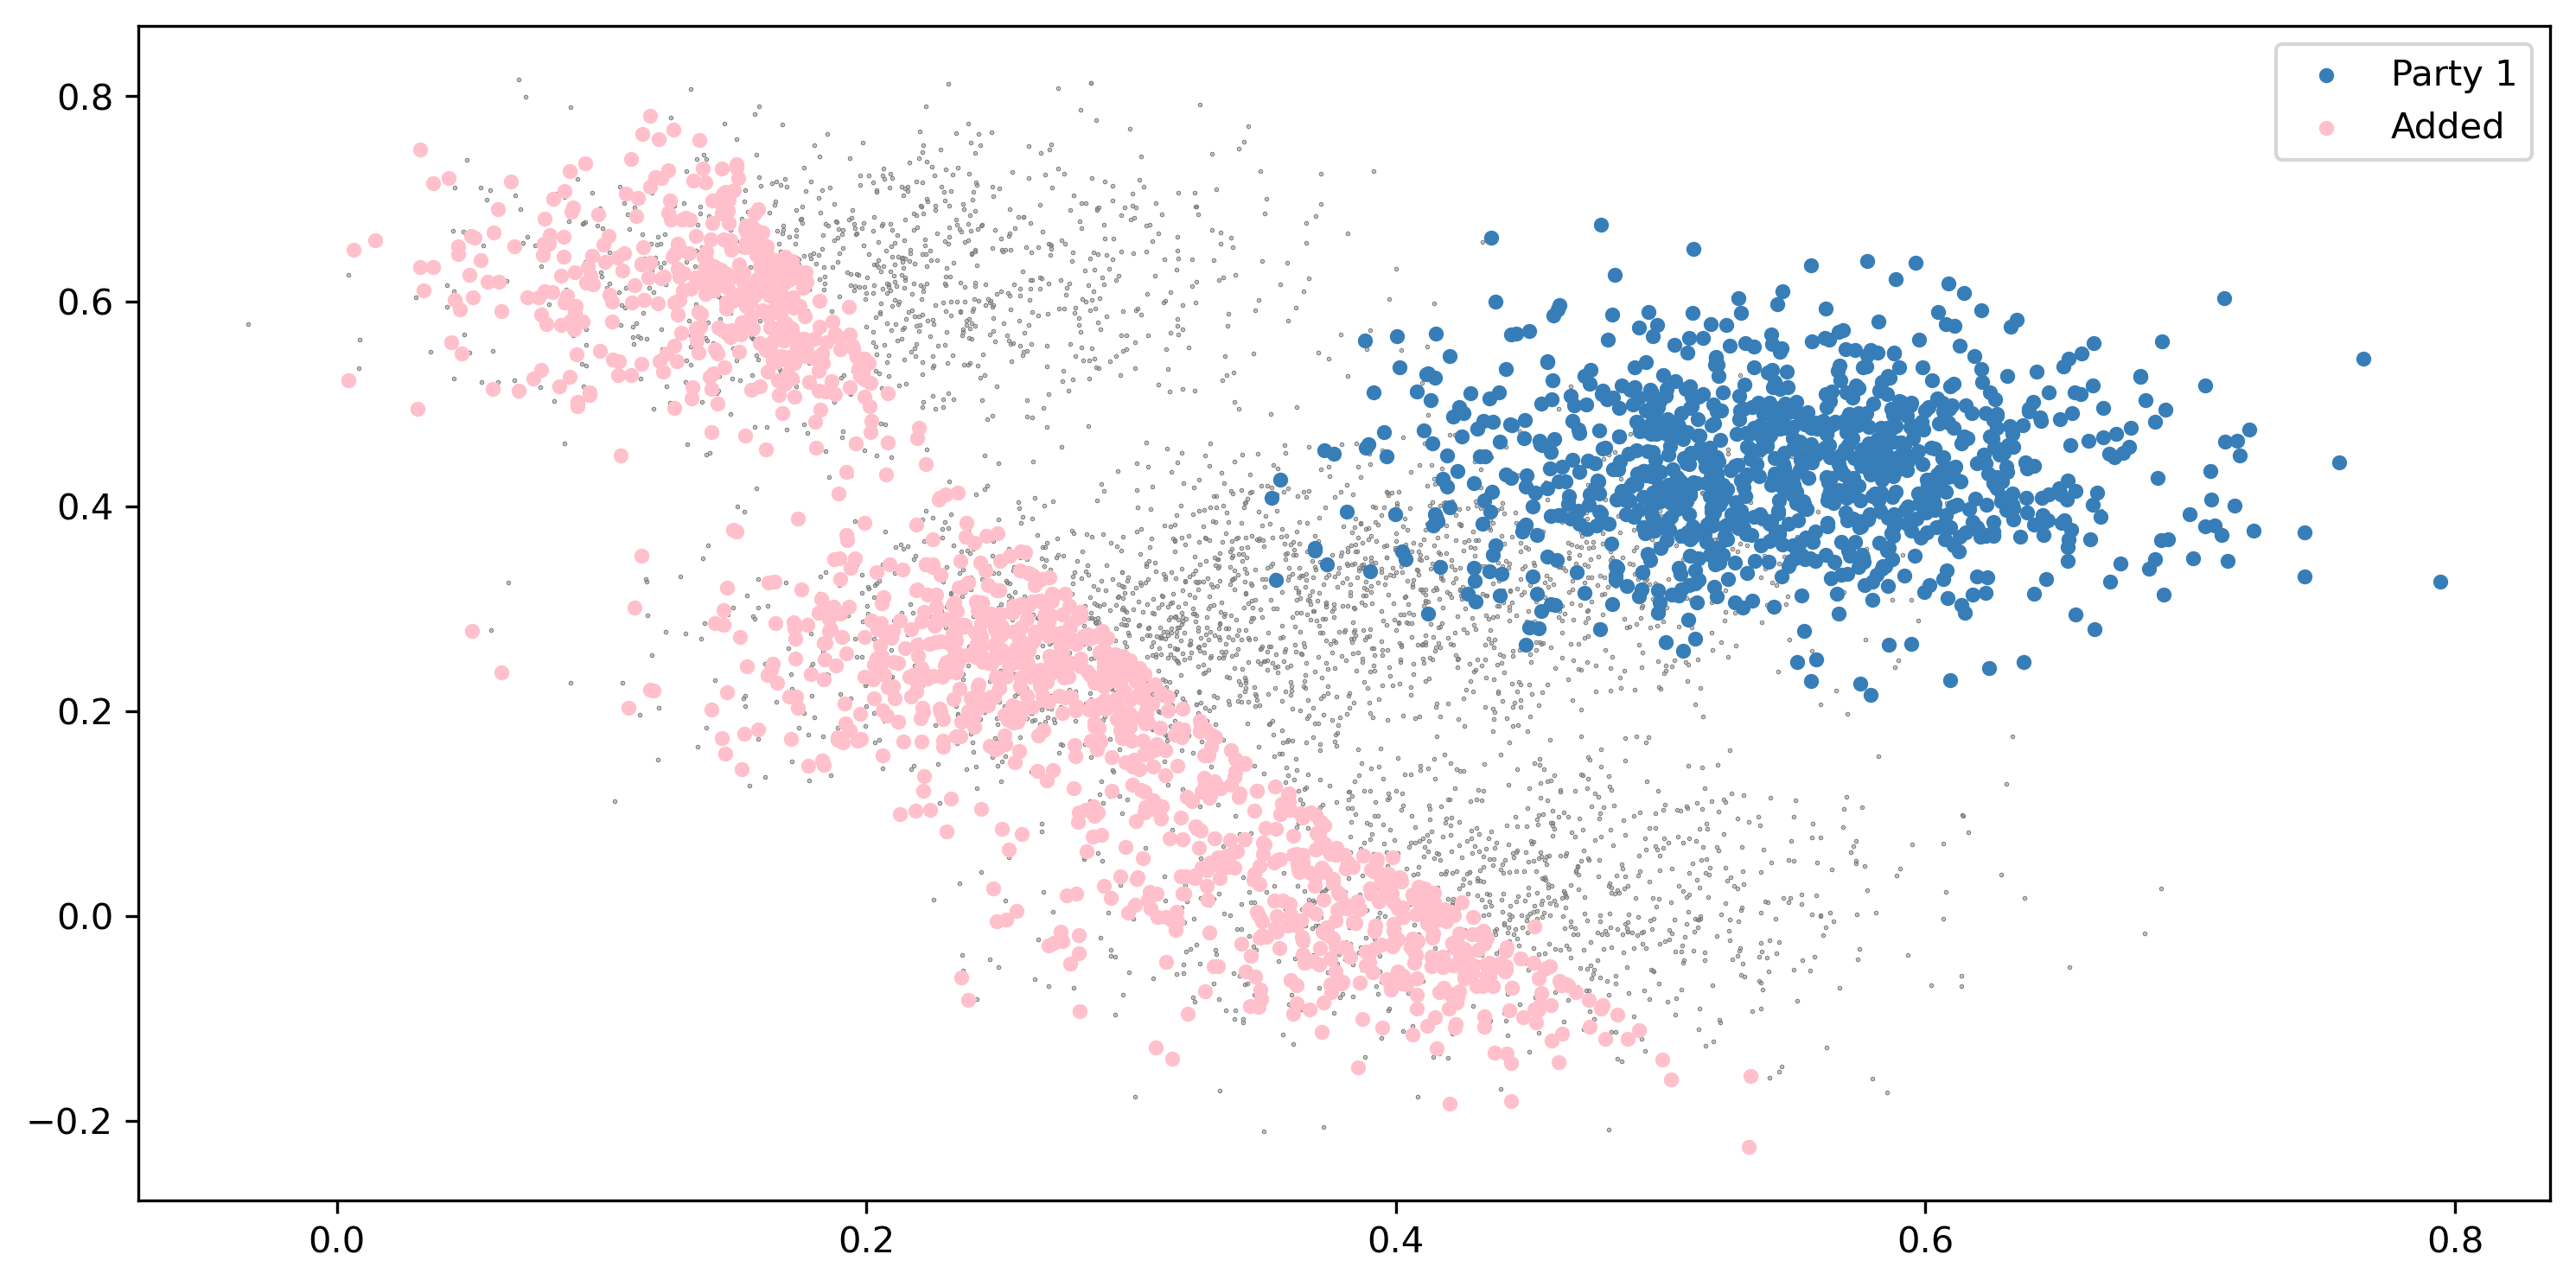

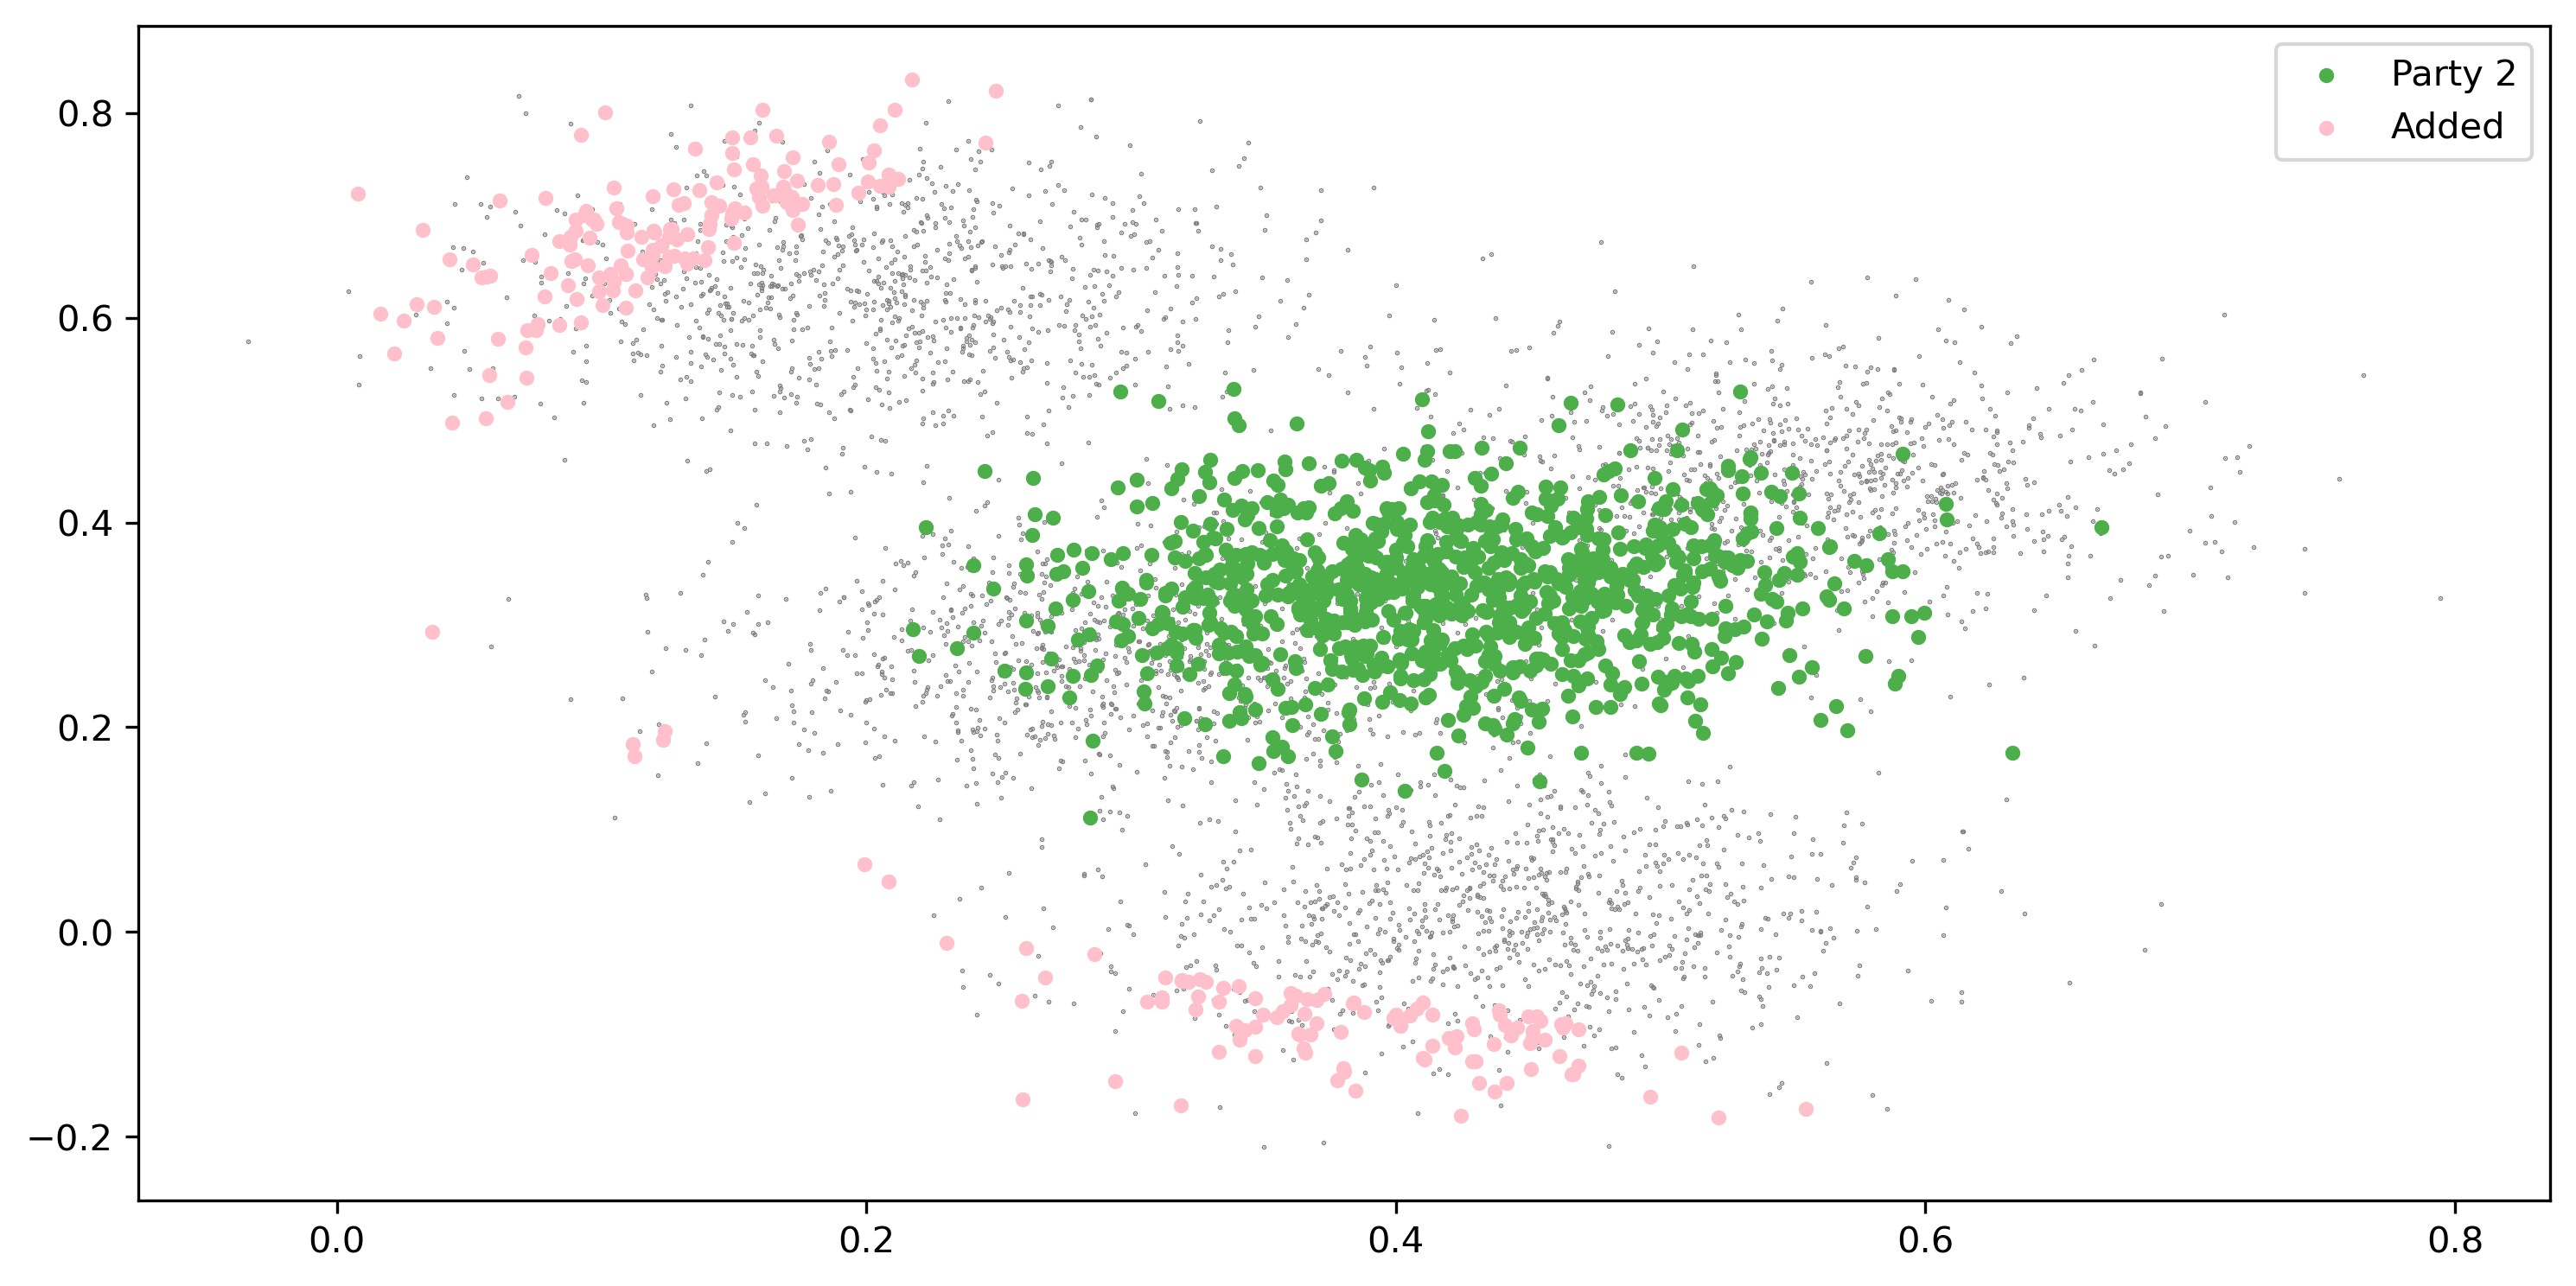

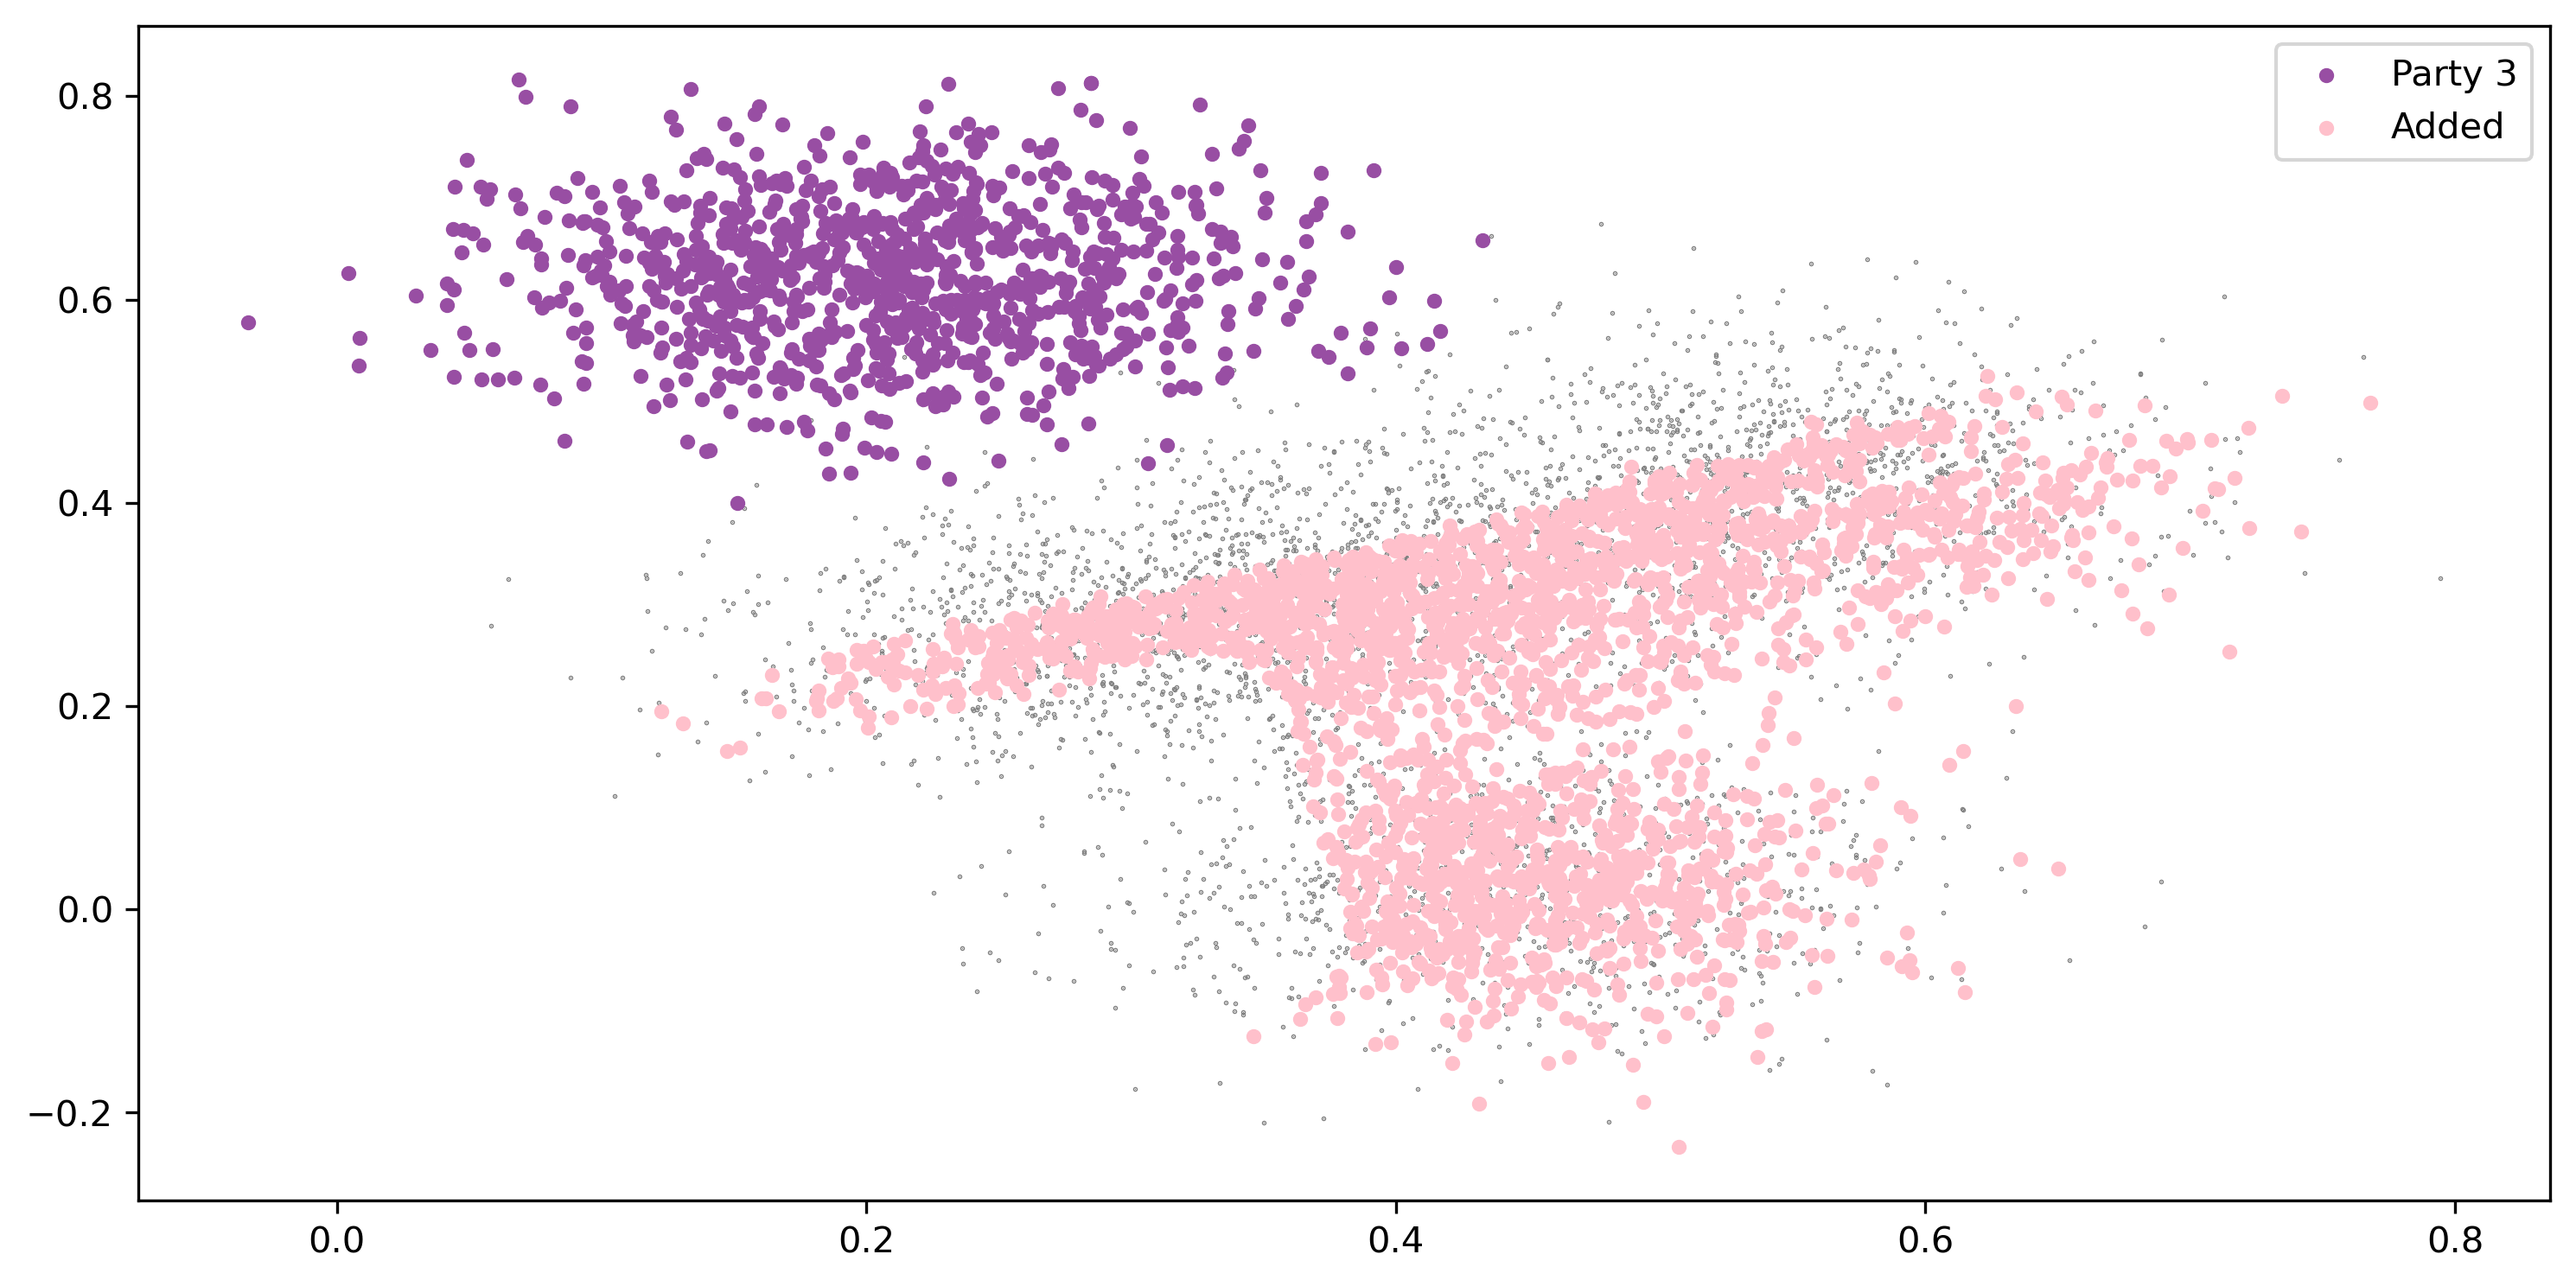

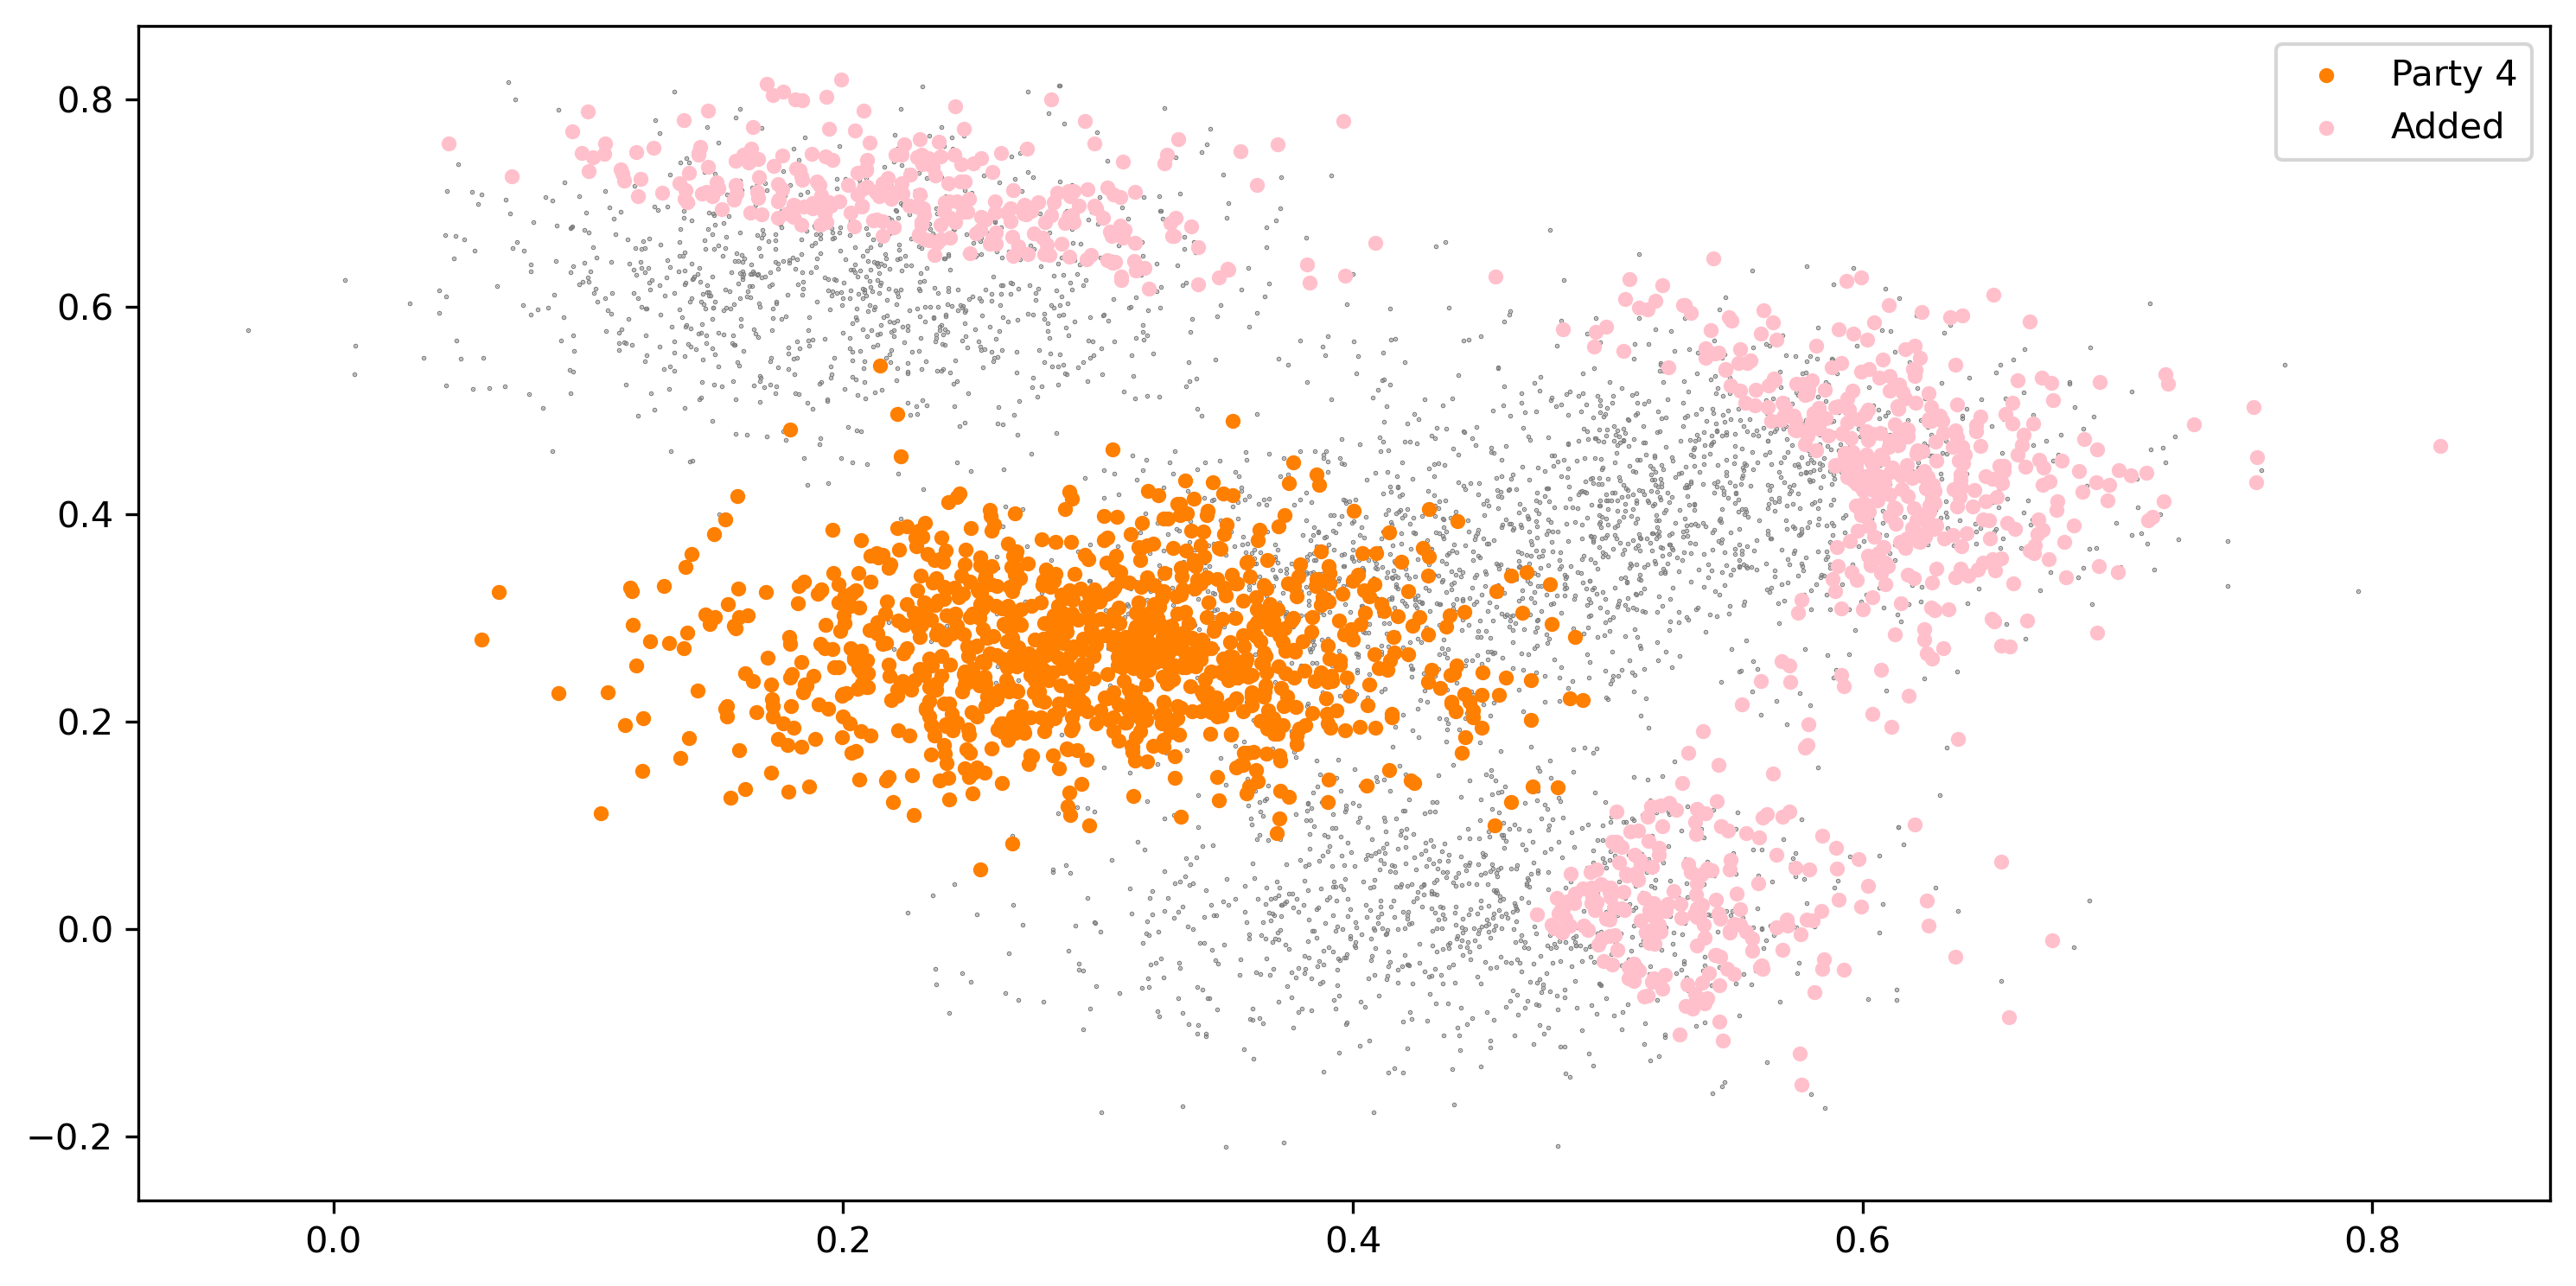

In [14]:
for party in range(5):
    plt.figure(figsize=(12, 6), dpi=300)
    #plt.gca().set_aspect('equal', adjustable='box')
    for i in range(num_clusters):
        if i != party:
            plt.scatter(test_sets[i, :, 0], test_sets[i, :, 1], s=0.1, color='grey')

    plt.scatter(test_sets[party, :, 0], test_sets[party, :, 1], s=10, color=cm.get_cmap('Set1')(party*(1/9)), label="Party {}".format(party))

    plt.scatter(np.array(res[party])[:, 0], np.array(res[party])[:, 1], s=10, color='pink', label="Added")
    plt.legend()

## Controlled convergence rate (CCR)

In [15]:
gmm = np.array([sample_GMM(means, covs, 500) for i in range(num_clusters)])
candidates = np.array([gmm[0]]*5)
phi = [1, 0.75, 0.5, 0.25, 0]
D = np.array([test_sets[0]] * 5)

In [16]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
kernel.base_kernel.lengthscale = [1, 1]
kernel.outputscale = 1

In [17]:
R, deltas, mus = con_conv_rate(candidates, reference, phi, D, kernel)

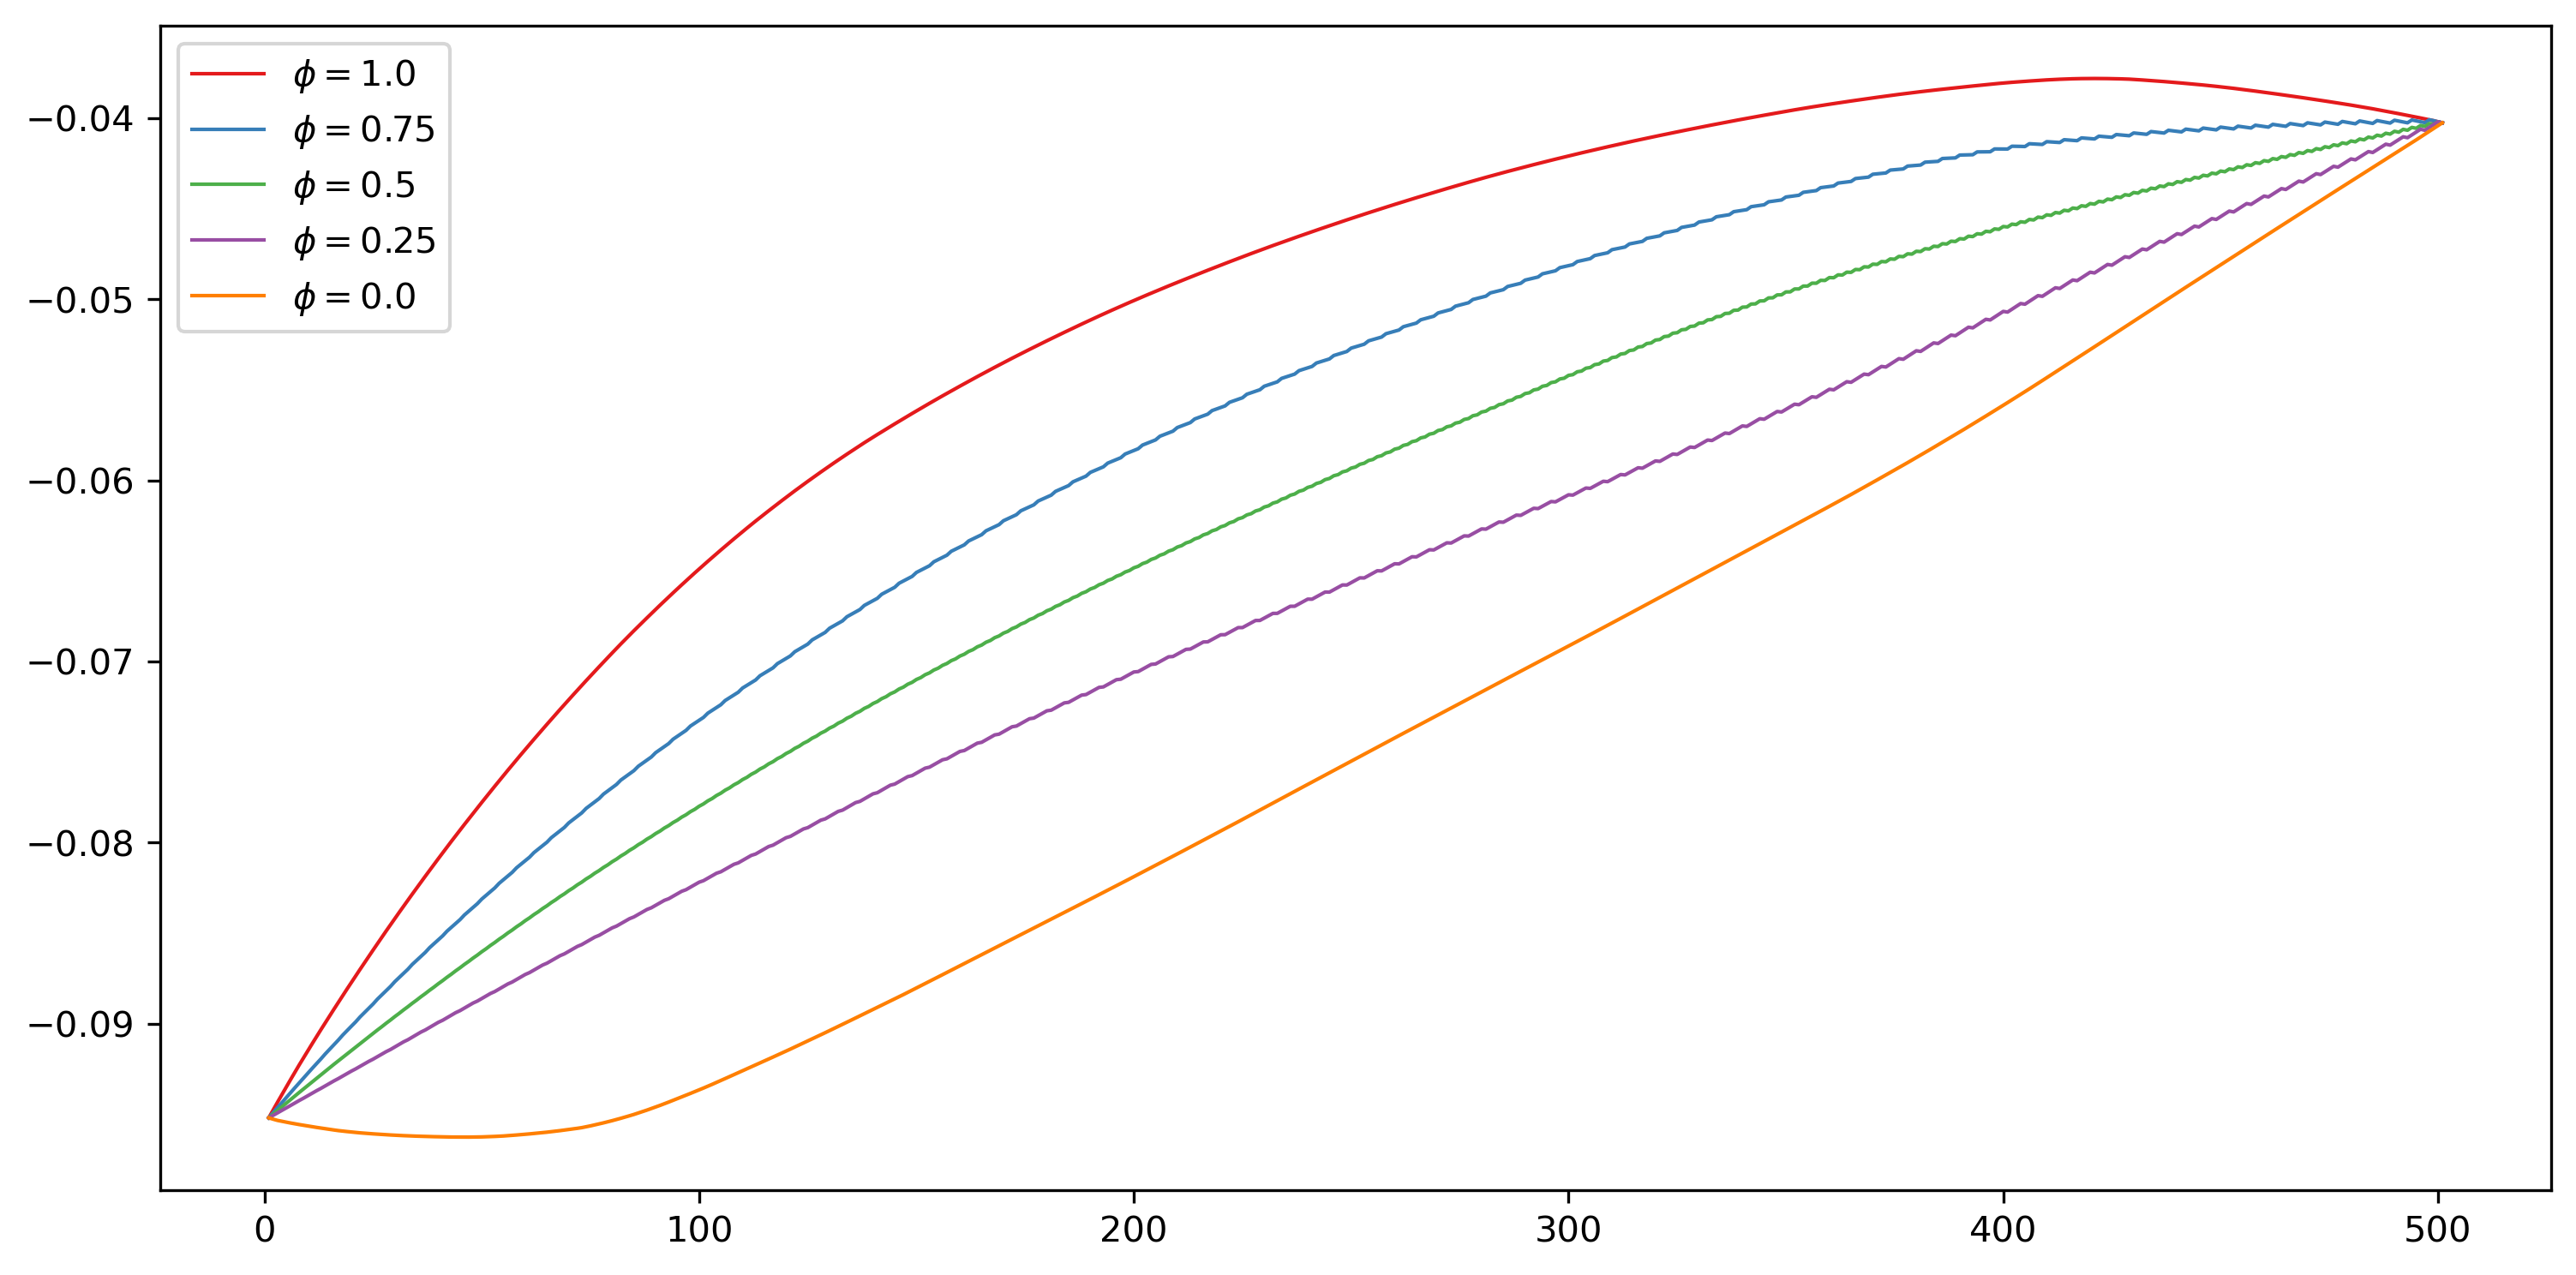

In [18]:
x = list(range(1, len(mus[0])+1))
plt.figure(figsize=(12, 6), dpi=300)

for i in range(len(mus)):
    plt.plot(x, mus[i], 'C0', linewidth=1, color=cm.get_cmap('Set1')(i*(1/9)), label="$\phi = ${}".format(1 - i*0.25))

    plt.legend()

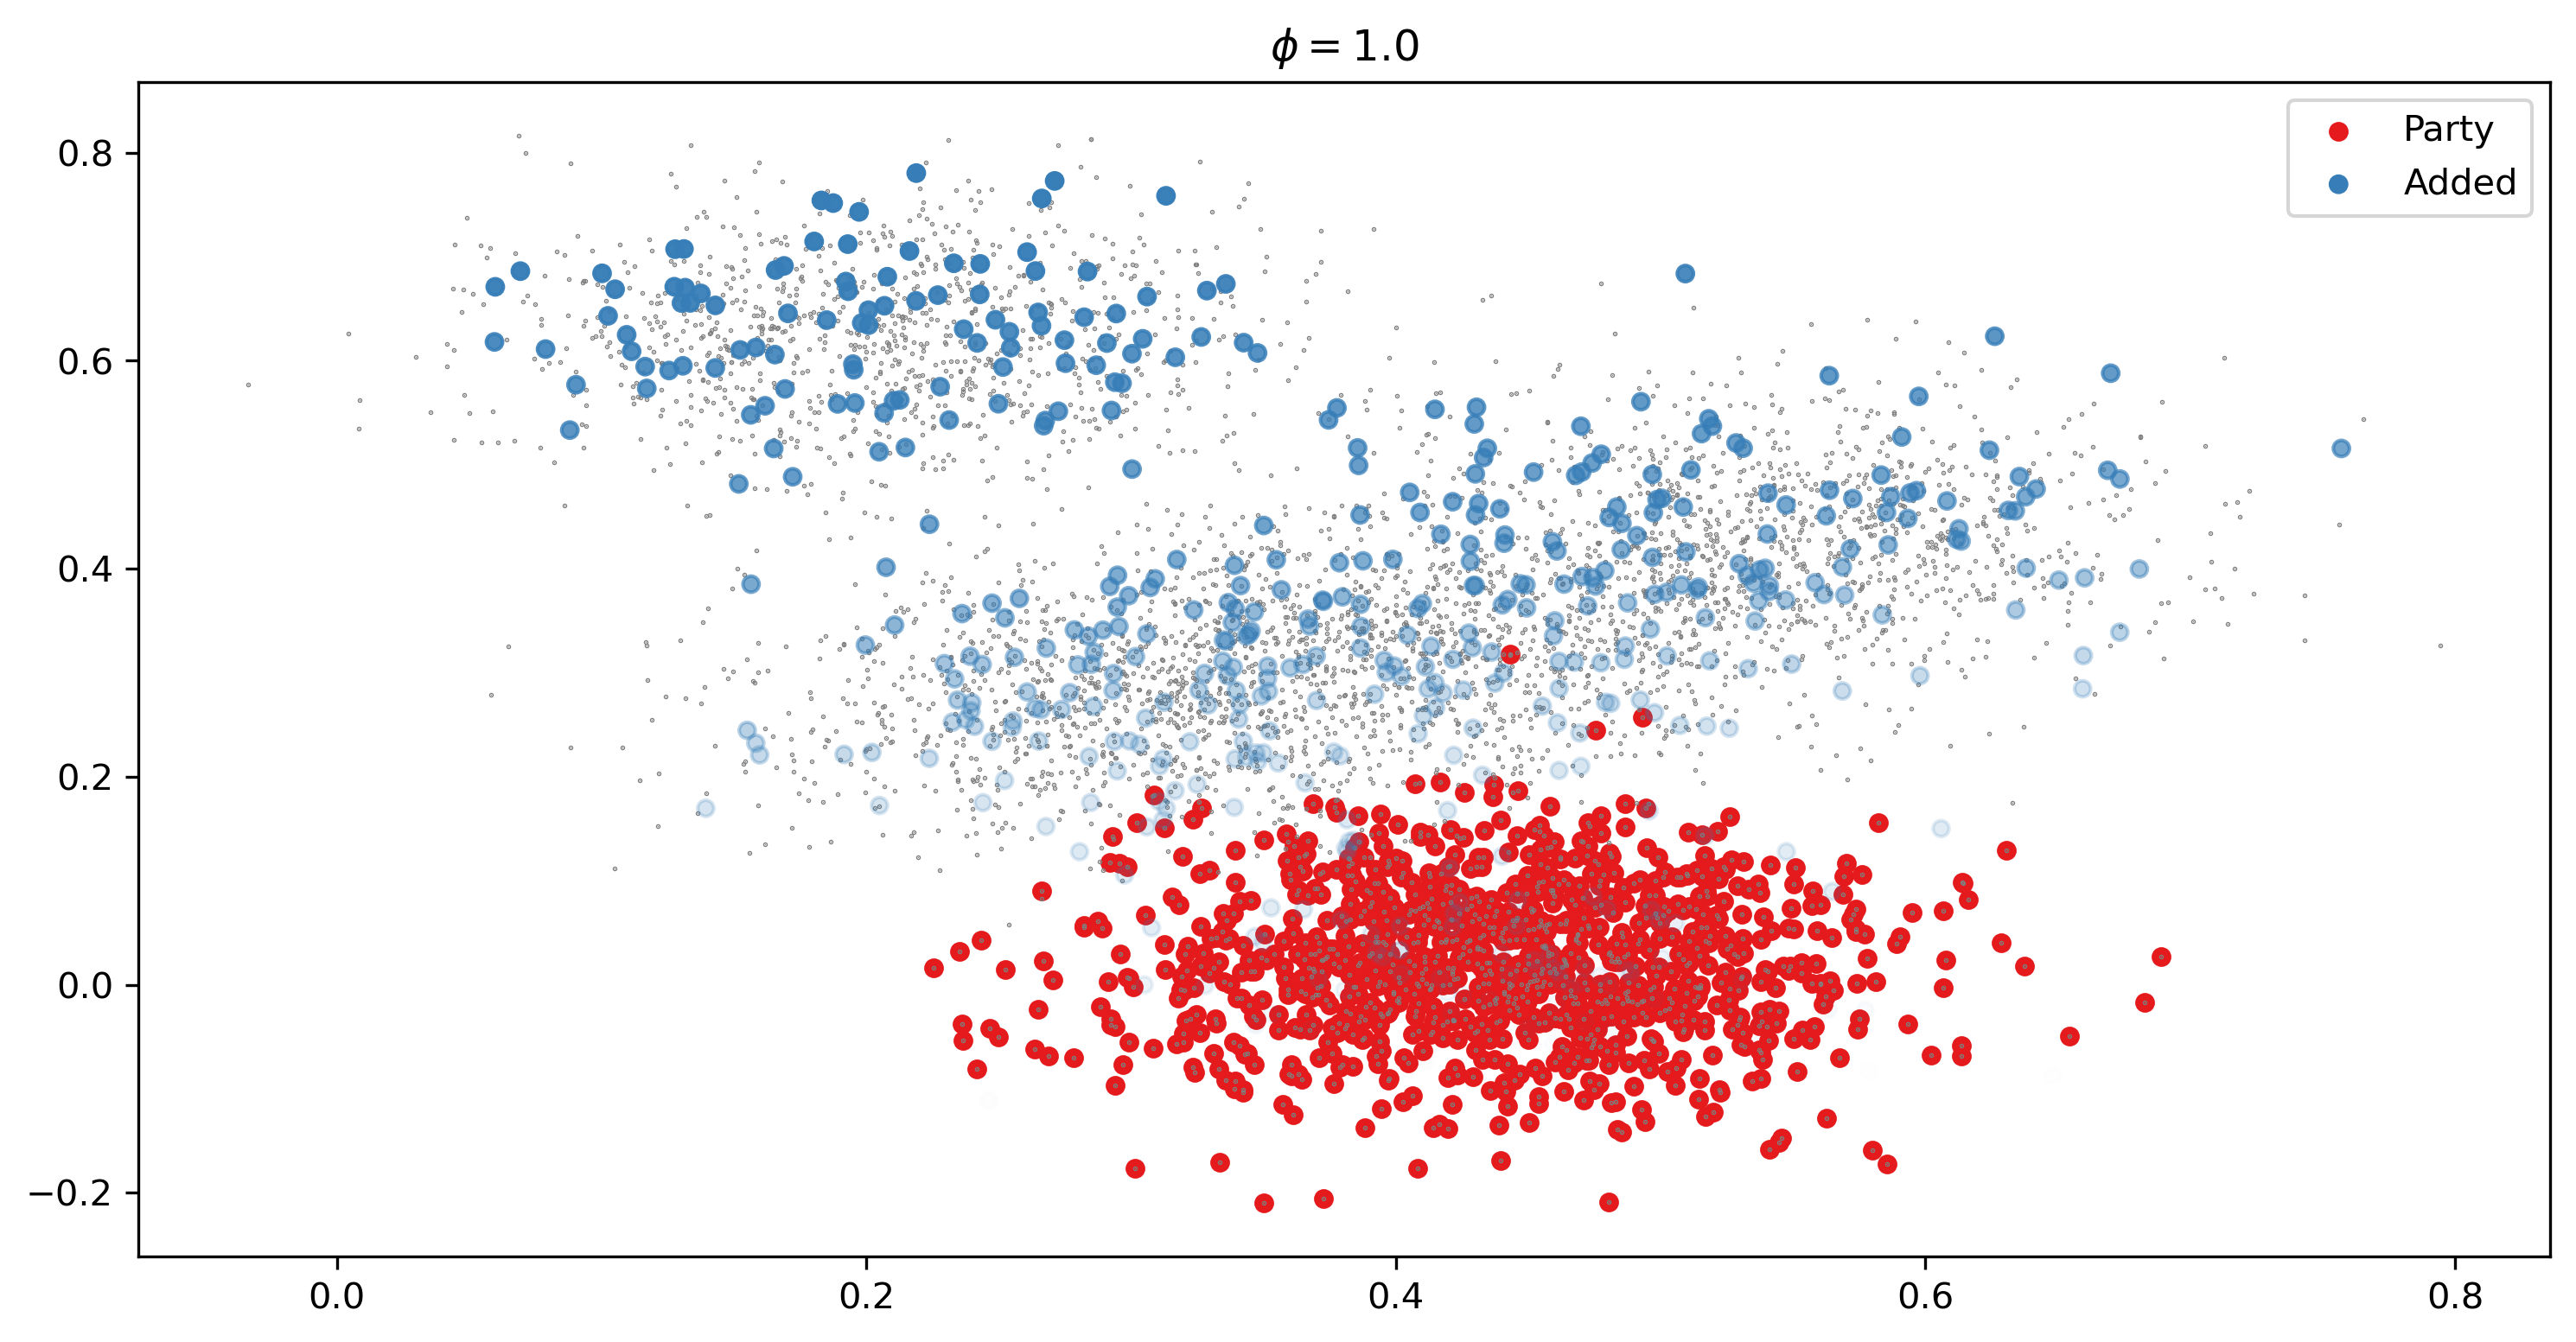

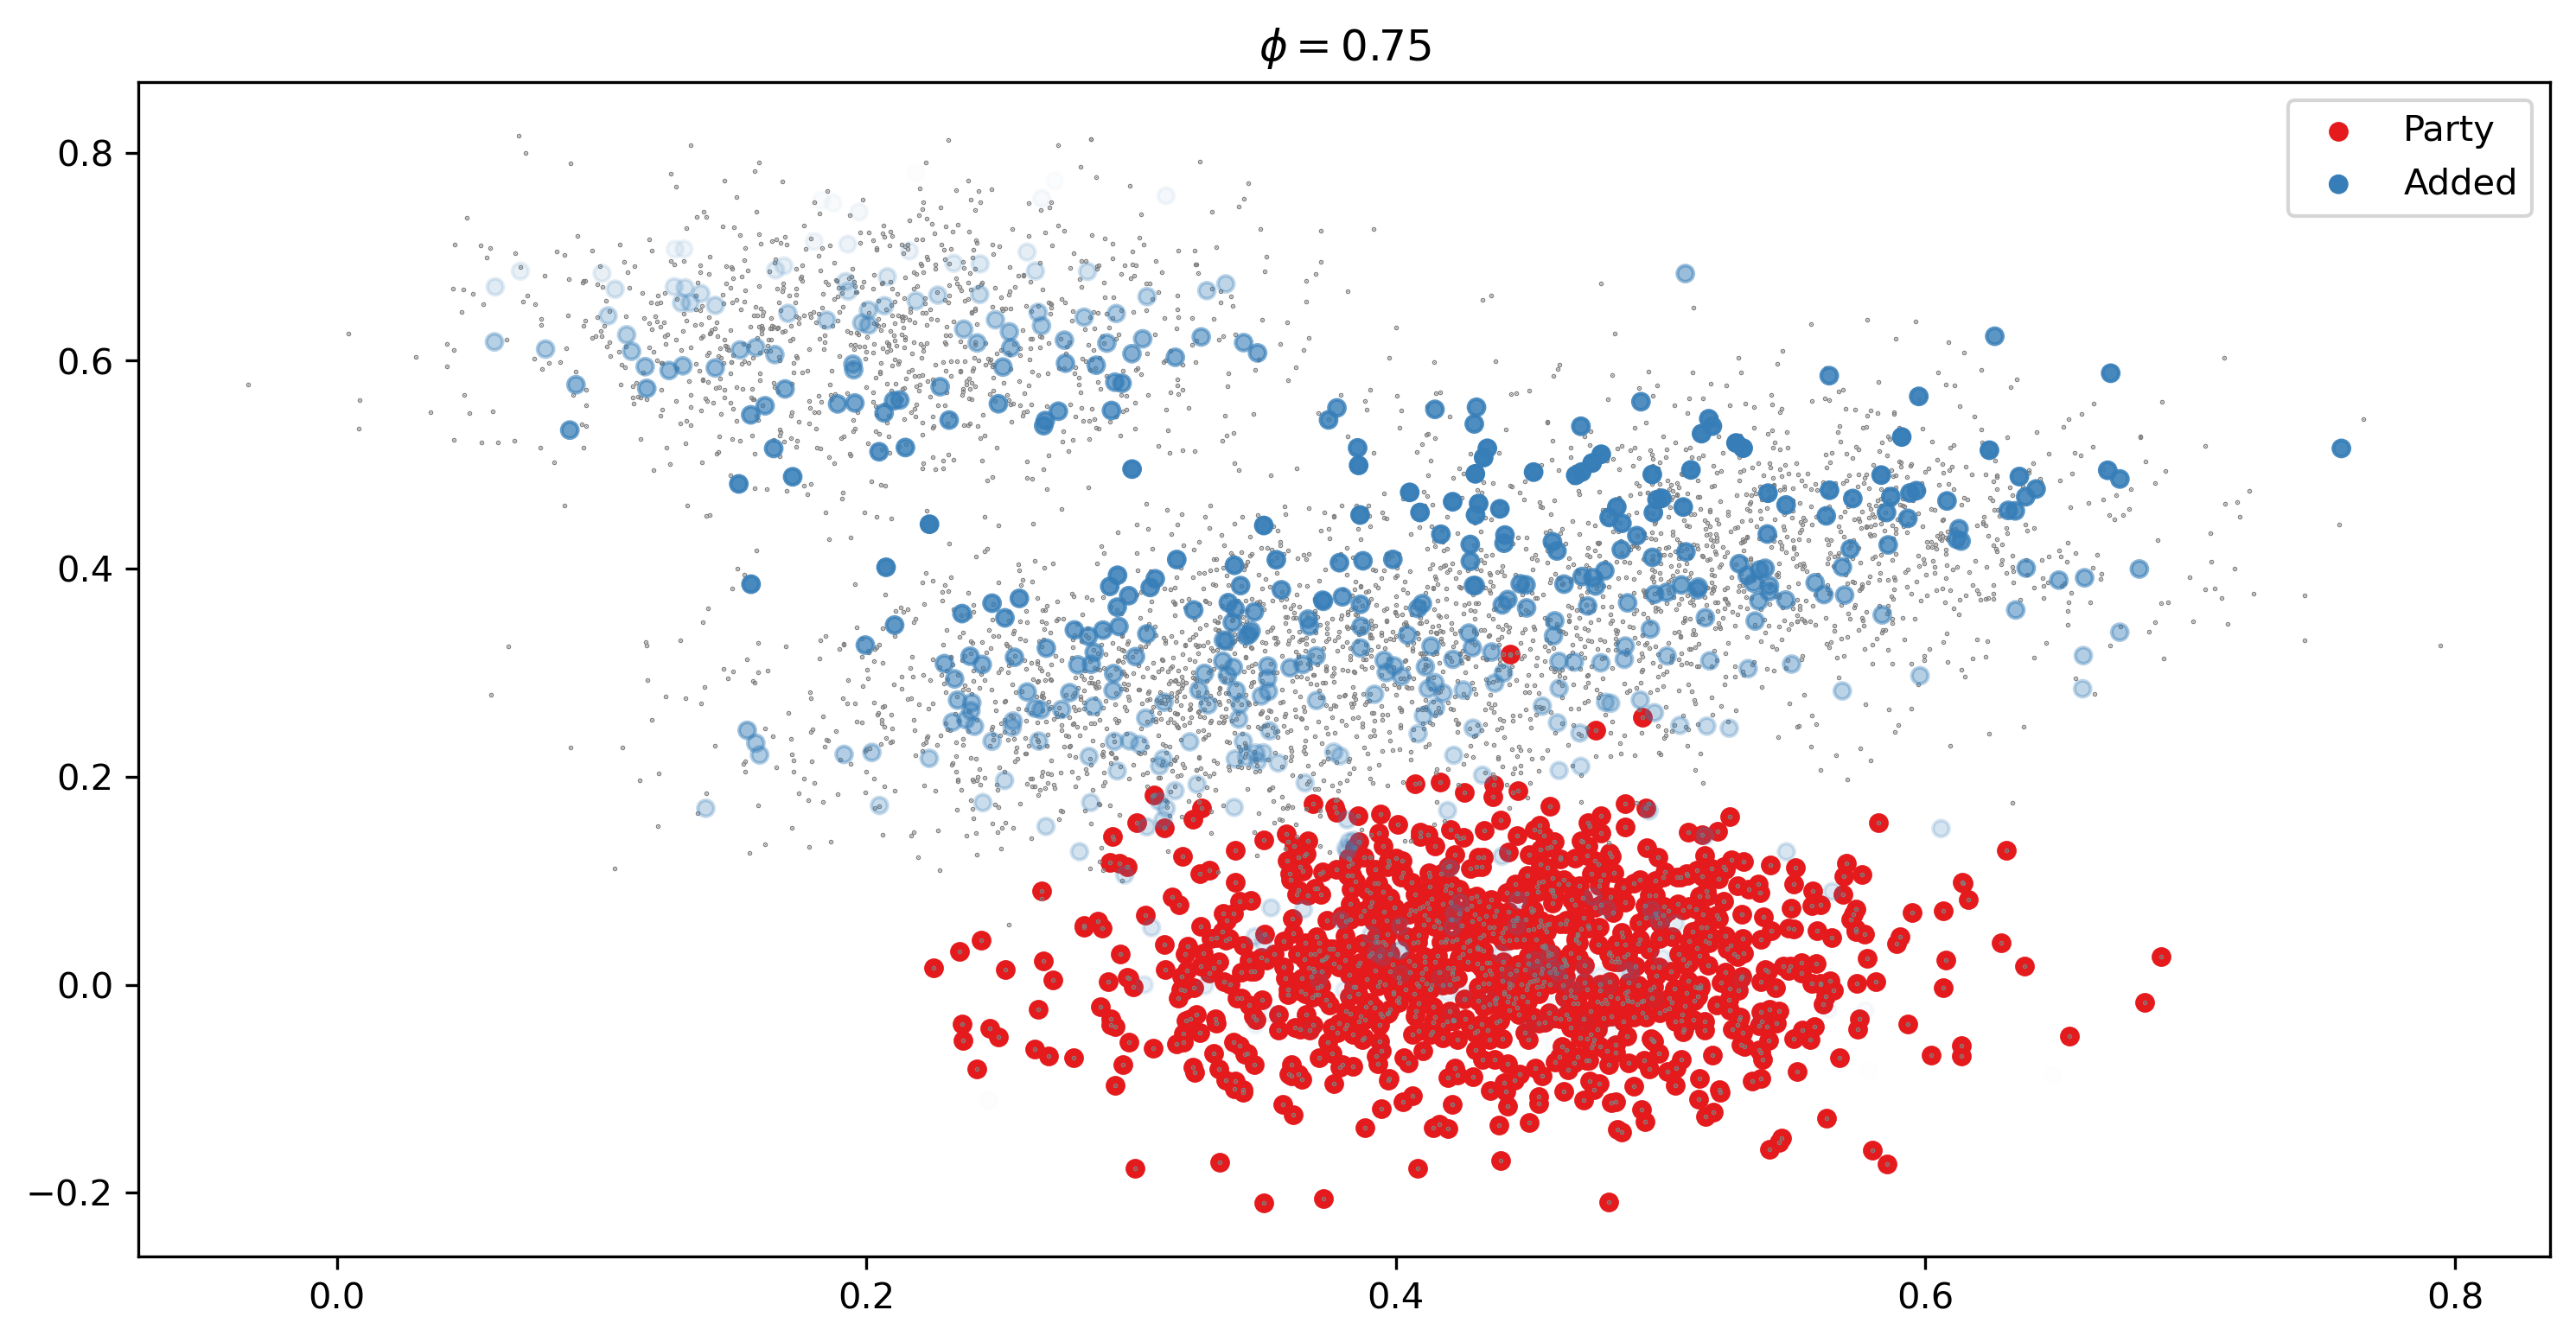

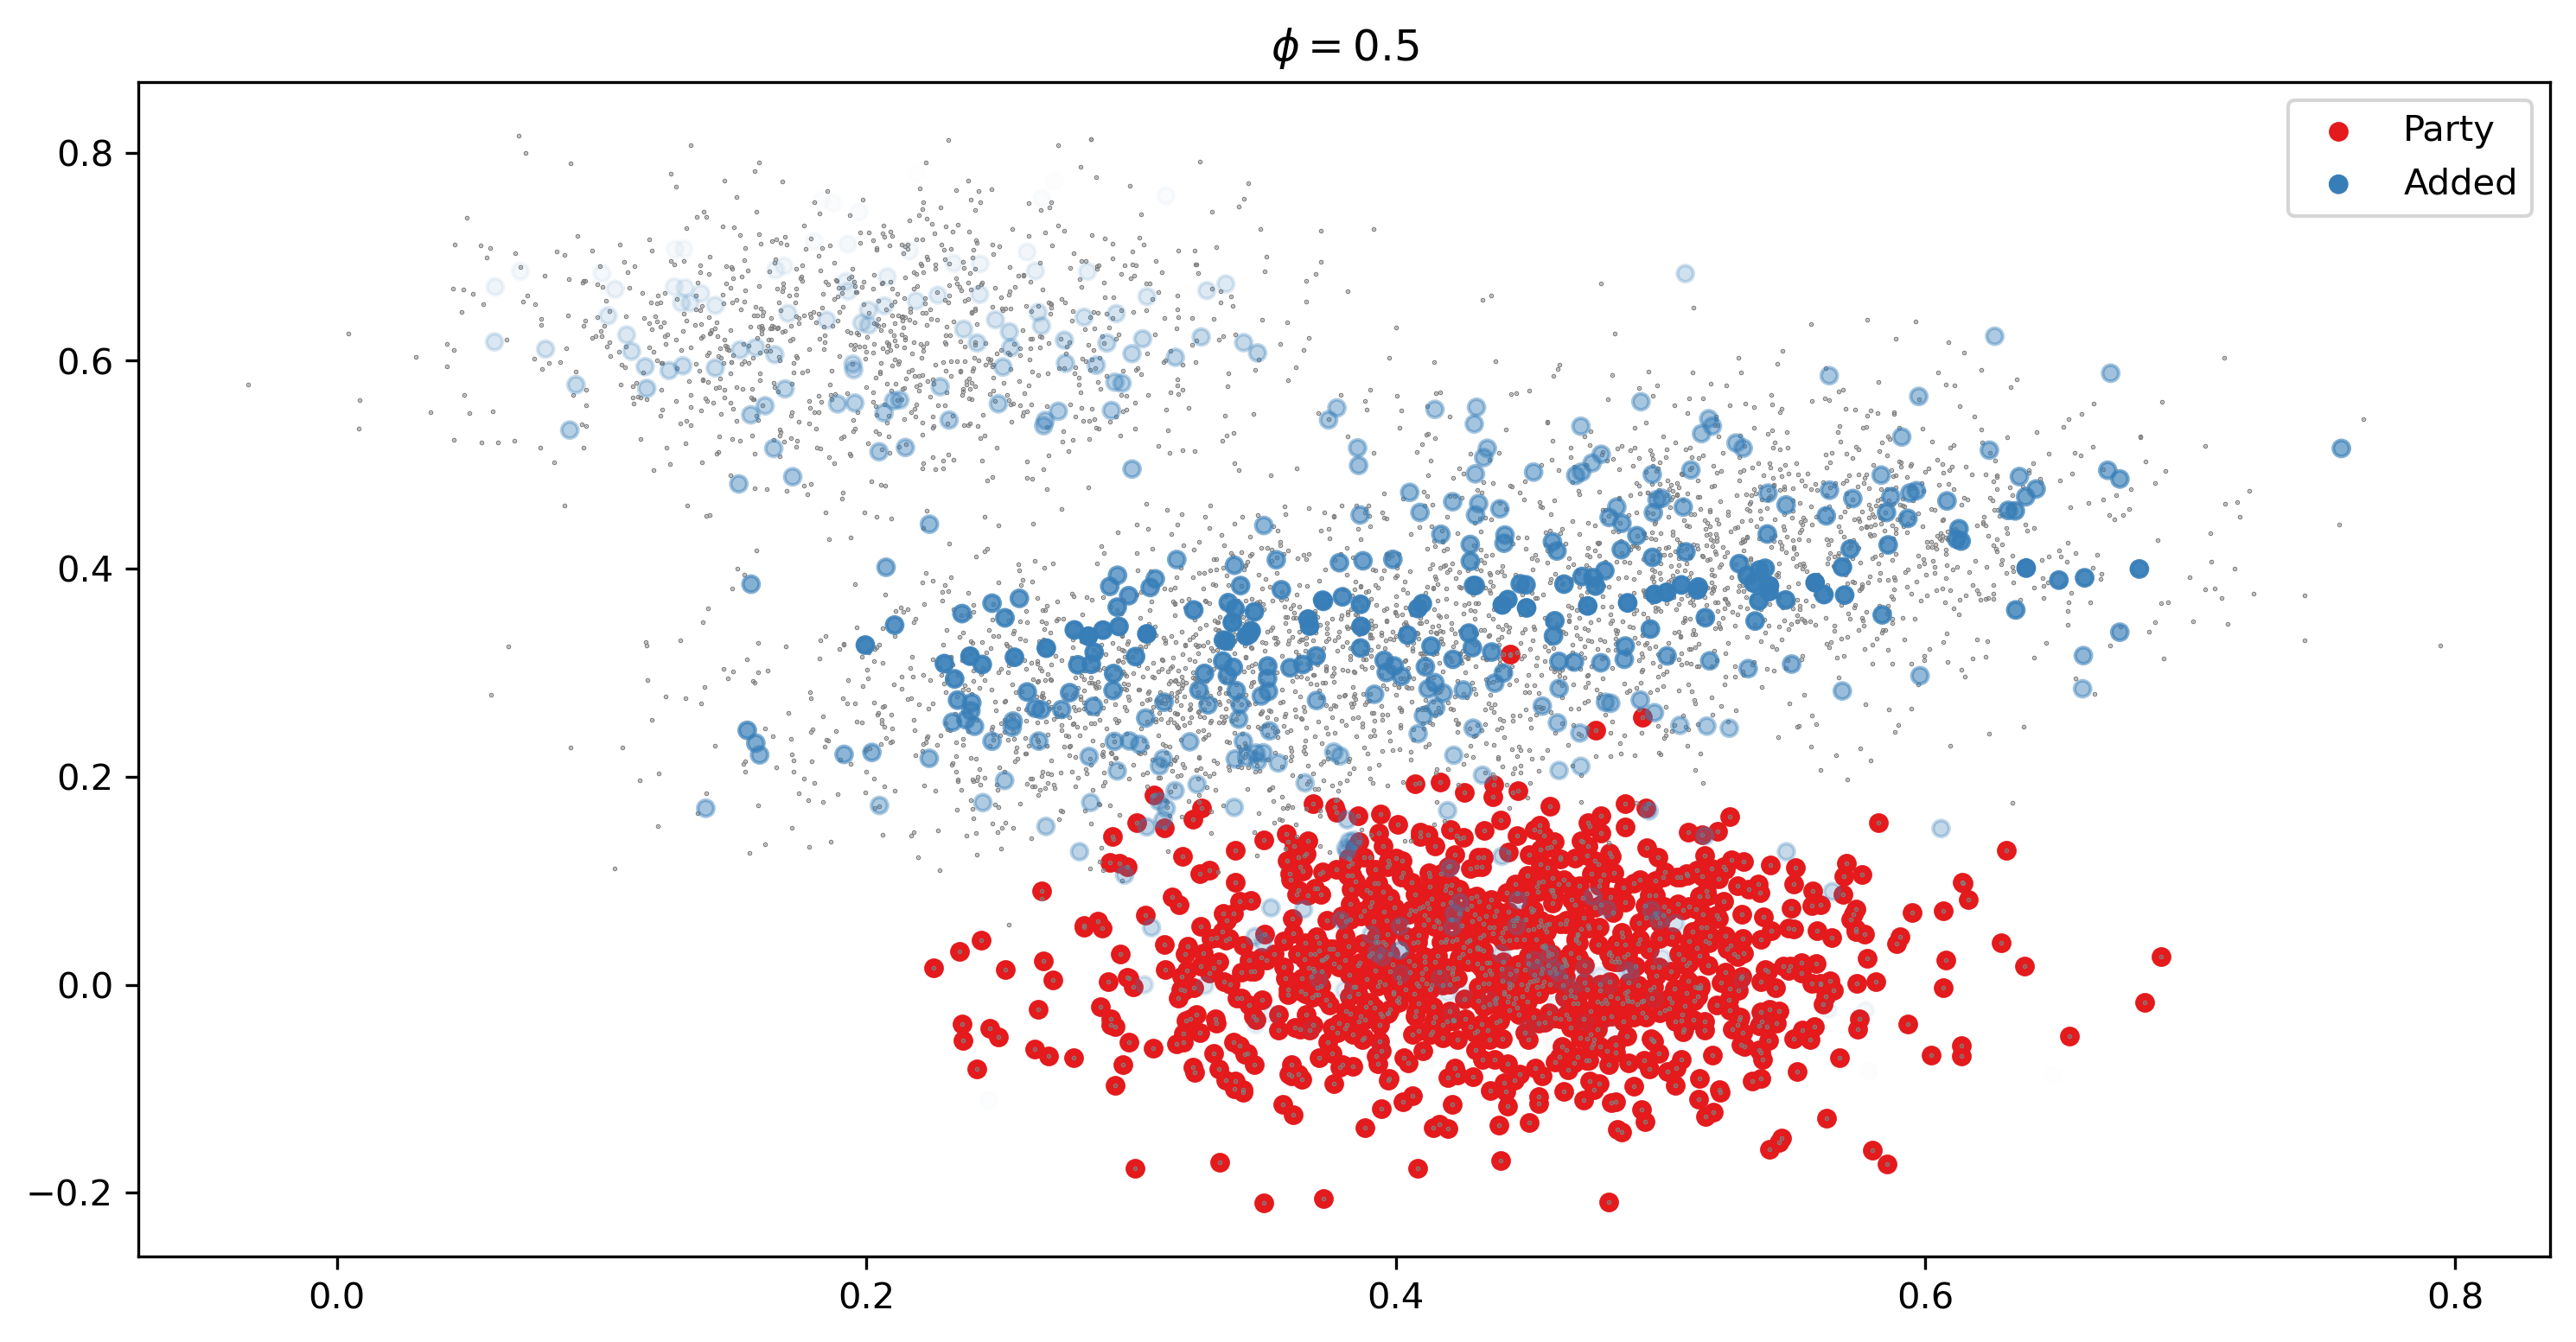

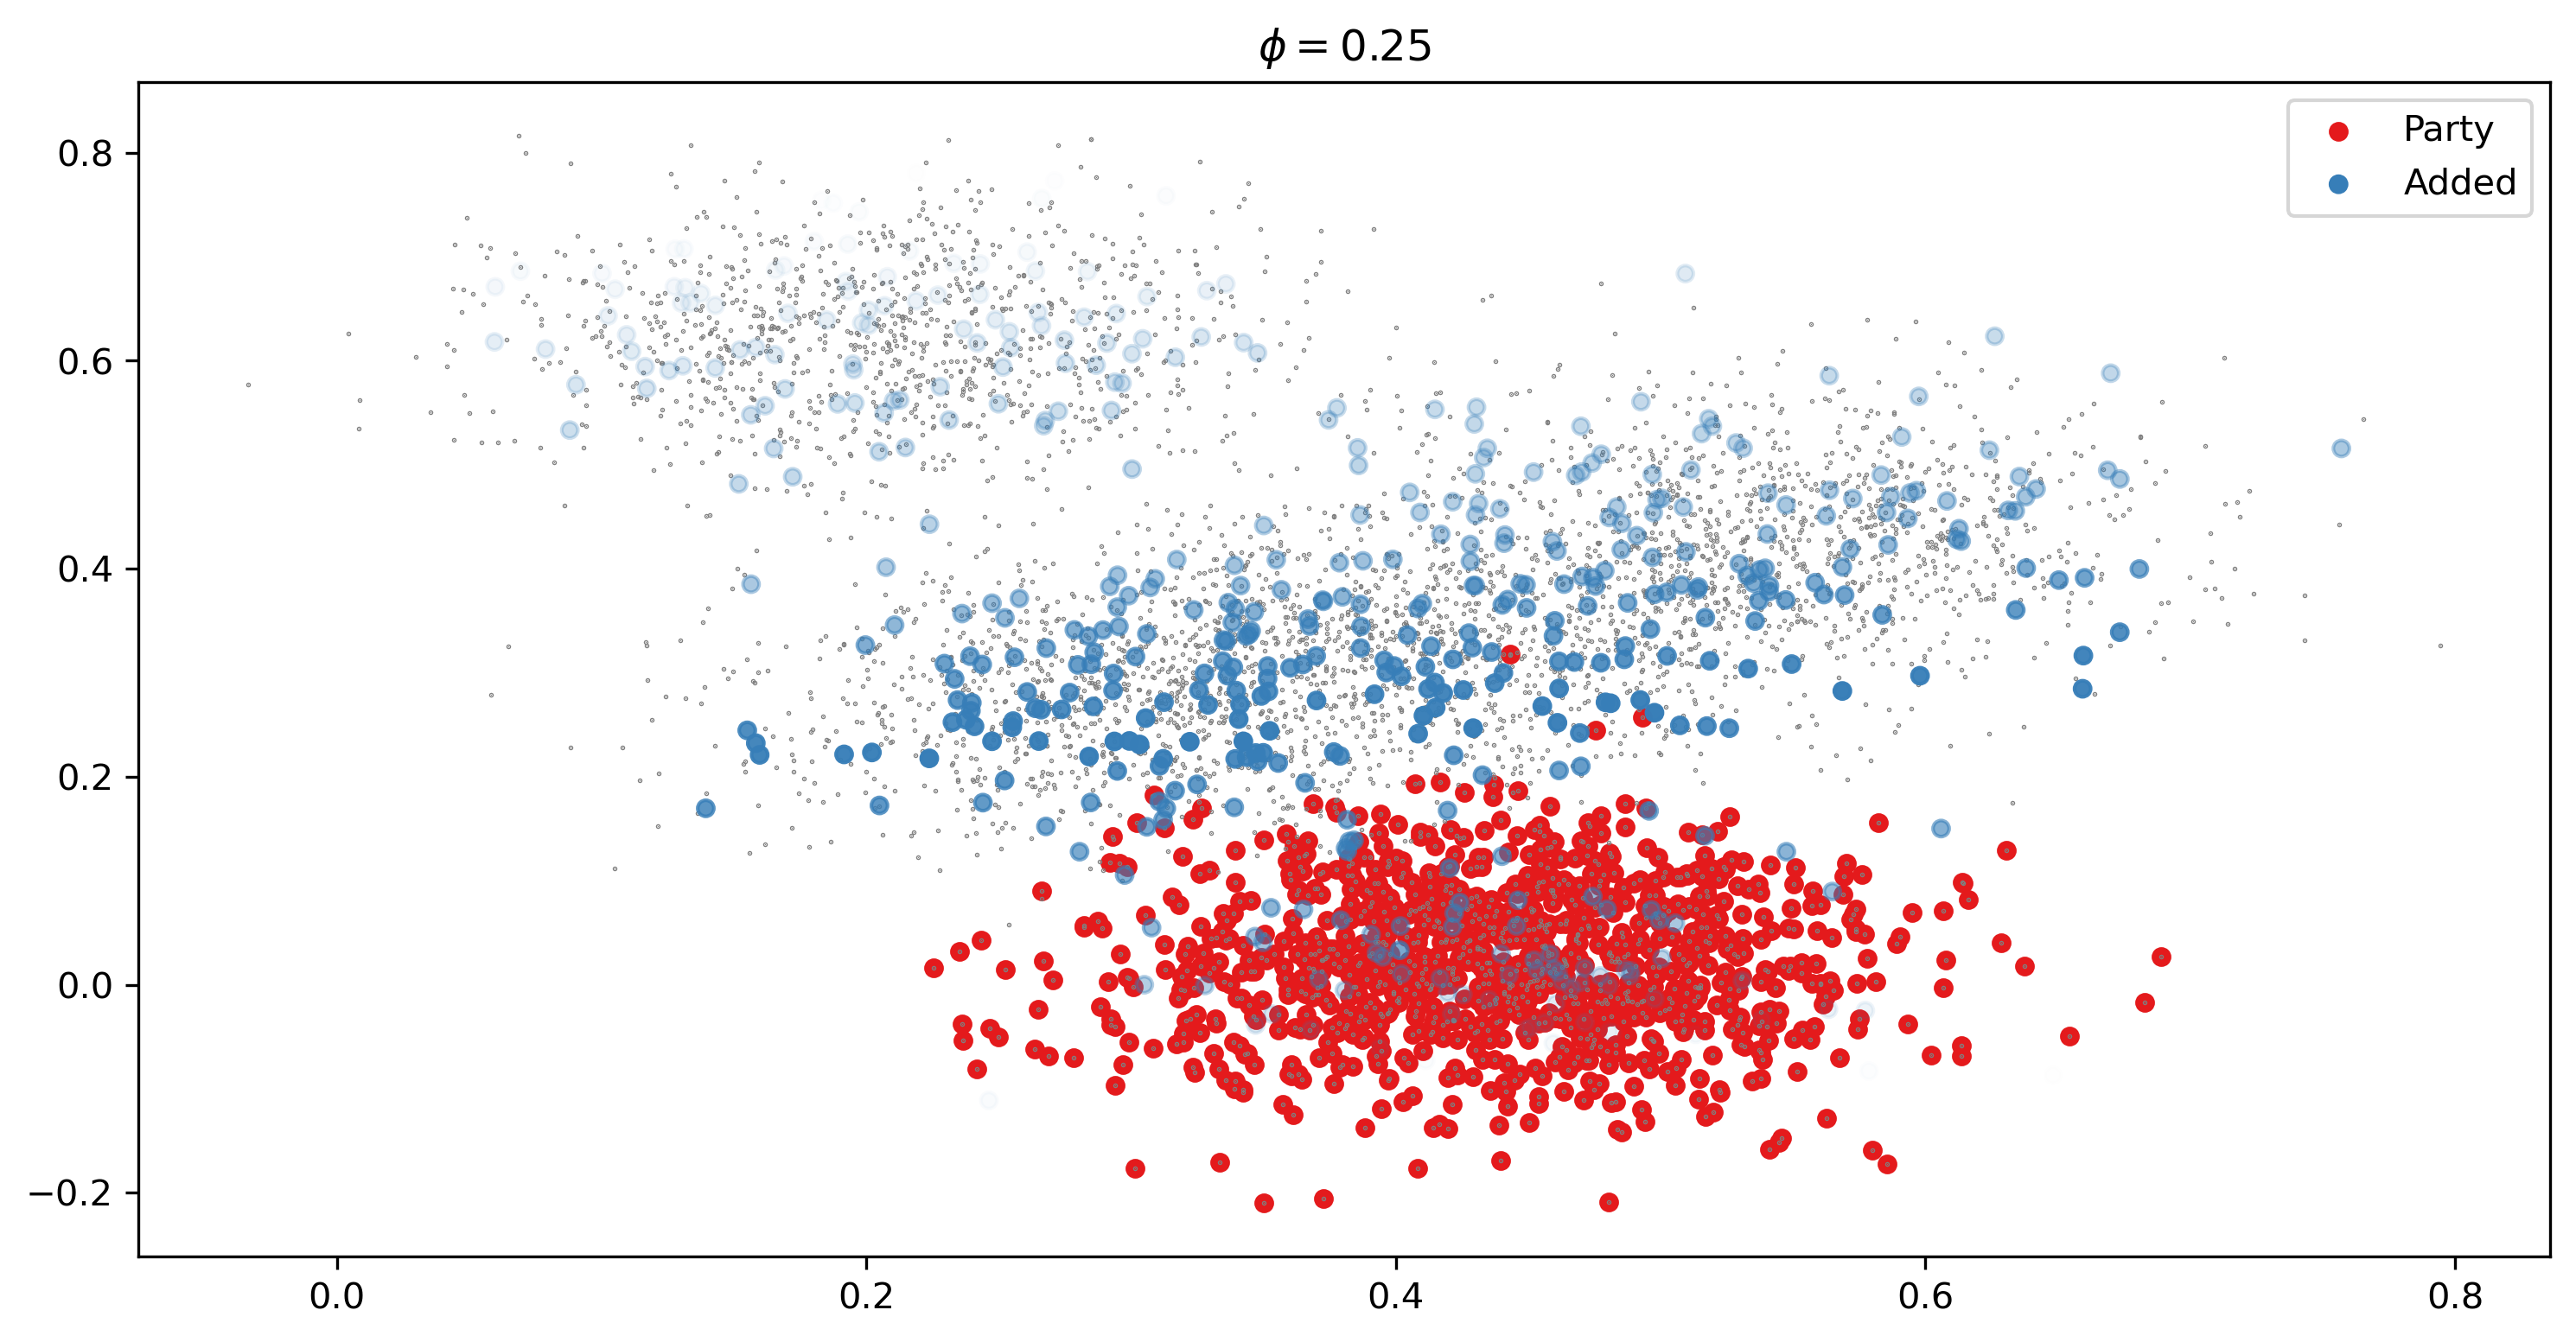

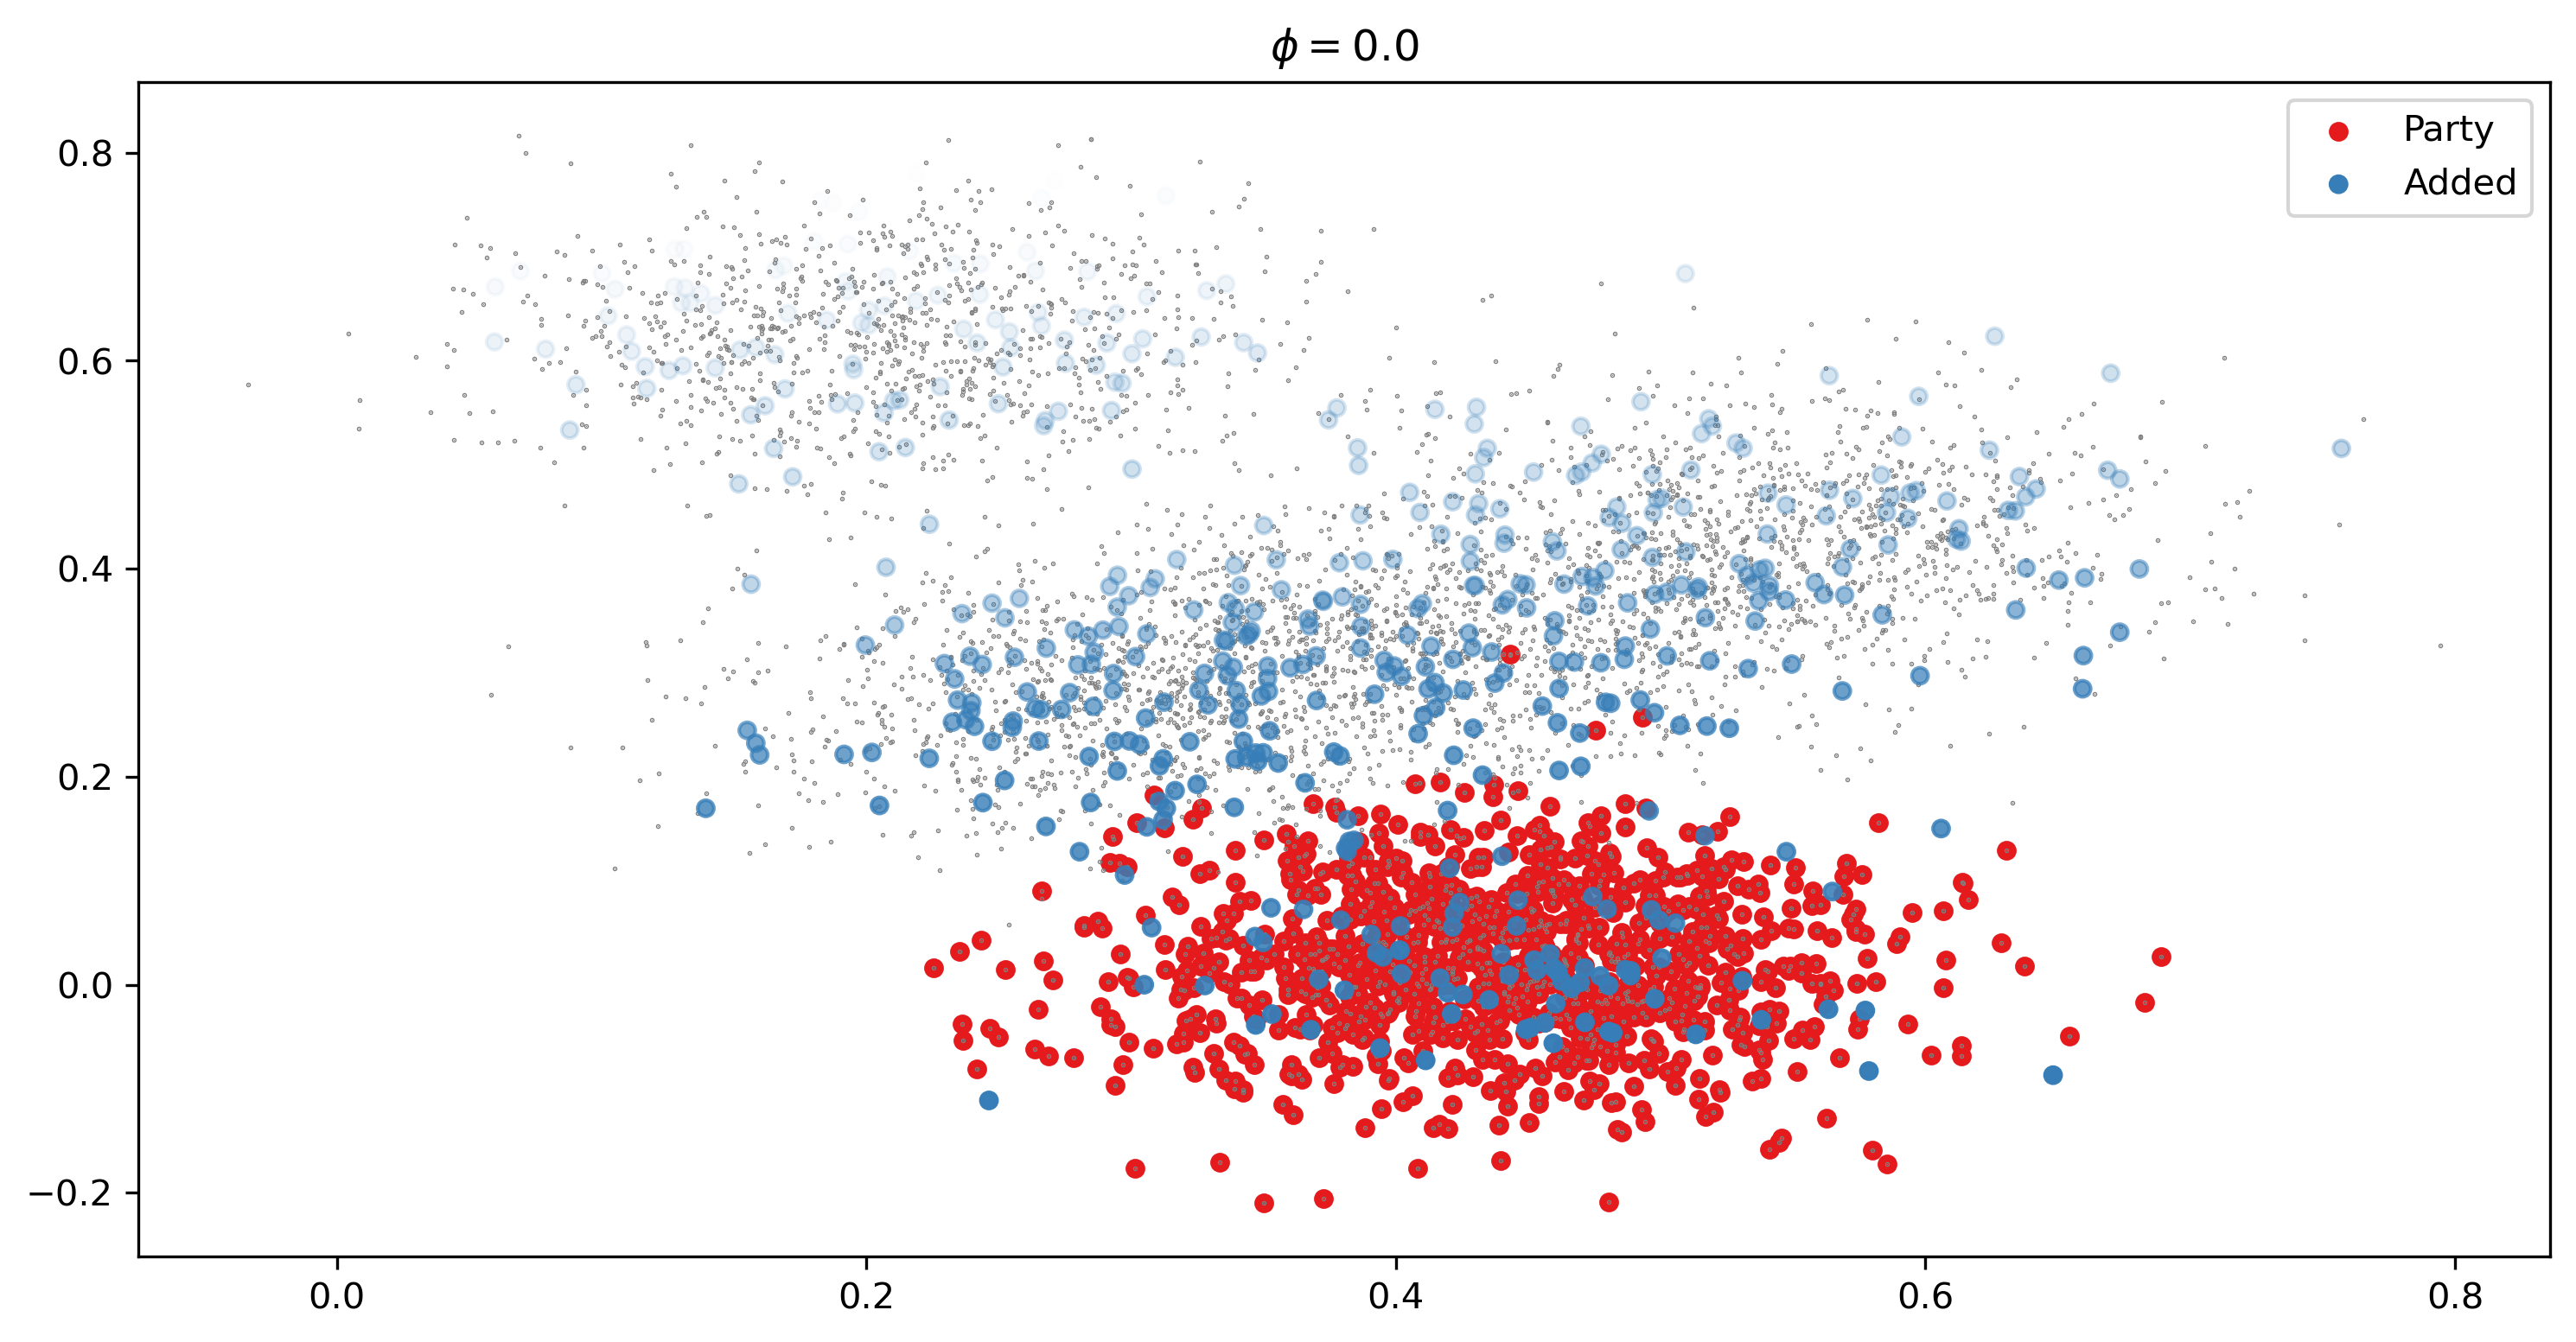

In [19]:
for reward in range(len(R)):
    plt.figure(figsize=(12, 6), dpi=300)
    plt.scatter(D[0, :, 0], D[0, :, 1], s=20, color=cm.get_cmap('Set1')(0*(1/9)), label="Party")
    for i in range(num_clusters):
        plt.scatter(test_sets[i, :, 0], test_sets[i, :, 1], s=0.1, color='grey')
    
    added = np.array(R[reward])
    alphas = [1-i*(1/len(R[reward])) for i in range(len(R[reward]))]
    rgba_colors = np.zeros((len(R[reward]),4))
    rgba_colors[:, 3] = alphas
    rgba_colors[:, :3] = (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)
    plt.scatter(added[:, 0], added[:, 1], s=20, color=rgba_colors, label="Added")
    plt.legend()
    plt.title("$\phi = {}$".format(1 - reward*0.25))